<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fhybrid-models/models/advanced_spatial_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Proposed Improvements for Spatial Precipitation Models

### 1. Hyperparameter Optimization

| Parameter     | Original Value | Improved Value | Justification                 |
| ------------- | -------------- | -------------- | ----------------------------- |
| Batch Size    | 4              | **16**         | Greater gradient stability    |
| Learning Rate | 1e-3           | **5e-4**       | Smoother convergence          |
| Epochs        | 50             | **100**        | More time with early stopping |
| Patience      | 6              | **10**         | Prevent premature stopping    |
| Dropout       | 0              | **0.2**        | Regularization                |
| L2 Reg        | 0              | **1e-5**       | Prevent overfitting           |

### 2. Improved Architectures

#### Attention ConvLSTM (ConvLSTM\_Att)

```python
- 3 ConvLSTM layers (64→32→16 filters)
- CBAM (Channel + Spatial Attention)
- BatchNorm + Dropout in each layer
- Multi-scale head (1×1, 3×3, 5×5)
```

#### Residual ConvGRU (ConvGRU\_Res)

```python
- Skip connections from input
- Enhanced BatchNorm
- 2 ConvGRU blocks (64→32 filters)
- Final residual connection
```

#### Hybrid Transformer (Hybrid\_Trans)

```python
- CNN temporal encoder
- Multi-head attention (4 heads)
- LSTM for temporal aggregation
- Spatial decoder
```

### 3. Advanced Techniques

#### Learning Rate Scheduling

* **Warmup**: Initial 5 epochs
* **Cosine Decay**: Smooth reduction after warmup
* **ReduceLROnPlateau**: Additional reduction if stalled

#### Data Augmentation

* Gaussian noise (σ=0.005)
* Maintains spatial and temporal coherence

#### Regularization

* Spatial dropout (0.2)
* L2 regularization on all weights
* Batch Normalization

## 📈 Expected Improvements

### By Horizon:

* **H=1**: RMSE < 40 (\~8% improvement)
* **H=2**: RMSE < 30, R² > 0.5 (significant improvement)
* **H=3**: RMSE < 65, R² > 0.65 (\~10% improvement)

### By Model:

1. **ConvLSTM\_Att**: Improved capture of relevant spatial patterns
2. **ConvGRU\_Res**: Greater stability and reduced temporal degradation
3. **Hybrid\_Trans**: Enhanced modeling of long-range dependencies

## 🚀 Next Steps

### Short-term:

1. Train models with improved configurations
2. Validate metric improvements
3. Regional error analysis

### Medium-term:

1. **Ensemble Methods**: Combine best models
2. **Multi-Task Learning**: Predict multiple variables simultaneously
3. **Physics-Informed Loss**: Incorporate physical constraints

### Long-term:

1. **3D Models**: ConvLSTM3D to capture elevation
2. **Graph Neural Networks**: Address irregular spatial relations
3. **Uncertainty Quantification**: Confidence intervals

## 🔍 Baseline Comparison

The script automatically generates comparisons with original models, displaying:

* % improvement in RMSE
* Evolution of R² per horizon
* Summary table of best models


In [ ]:
# ───────────────────────── IMPORTS Y CONFIGURACIÓN ─────────────────────────
from __future__ import annotations
from pathlib import Path
import sys, os, gc, warnings
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, ConvLSTM2D, LSTM,SimpleRNN, LSTM, GRU, Flatten, Dense, Reshape, RepeatVector,
    Lambda, Permute, Layer, TimeDistributed, BatchNormalization, Dropout, Add,
    Add, Multiply, Concatenate, GlobalAveragePooling2D, Activation,
    LayerNormalization, MultiHeadAttention, MaxPooling2D, Embedding, Conv3D
)
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,
    CSVLogger, Callback, LearningRateScheduler
)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import imageio.v2 as imageio
from IPython.display import clear_output, display, Image
import json
from datetime import datetime
from typing import List, Dict, Any, Tuple, Optional



## ╭─────────────────────────── Paths ──────────────────────────╮
# ▶️ Path configuration
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')
    # Install necessary dependencies
    !pip install -r requirements.txt
    !pip install xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn ace_tools_open cartopy geopandas
else:
    BASE_PATH = Path.cwd()
    for p in [BASE_PATH, *BASE_PATH.parents]:
        if (p / '.git').exists():
            BASE_PATH = p; break

print('BASE_PATH =', BASE_PATH)

import cartopy.crs as ccrs

# Paths
DATA_DIR = BASE_PATH / 'data' / 'output'
MODEL_OUTPUT_DIR = BASE_PATH/'models'/'output'
OUT_ROOT = BASE_PATH / 'models' / 'output' / 'advanced_spatial'
OUT_ROOT.mkdir(exist_ok=True)
BASE_MODEL_DIR = BASE_PATH / 'models' / 'output' / 'advanced_spatial' / 'base_models'
BASE_MODEL_DIR.mkdir(exist_ok=True)
MODEL_DIR = OUT_ROOT
SHAPE_DIR = BASE_PATH / 'data' / 'input' / 'shapes'
MODEL_INPUT_DIR = BASE_PATH/'data'/'input'/'shapes'
MODEL_INPUT_DIR.mkdir(parents=True, exist_ok=True)
IMAGE_DIR = MODEL_DIR/'images'
IMAGE_DIR.mkdir(exist_ok=True)
GIF_DIR = MODEL_DIR / "gifs"
GIF_DIR.mkdir(exist_ok=True)
# Dataset paths
FULL_NC = DATA_DIR / 'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation.nc'
FULL_NC_CLEAN = DATA_DIR / 'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc'
DEPT_GDF = gpd.read_file(SHAPE_DIR/'MGN_Departamento.shp')

print(f"📁 BASE_PATH: {BASE_PATH}")
print(f"📊 Dataset: {FULL_NC_CLEAN.name if FULL_NC_CLEAN.exists() else FULL_NC.name}")

# ───────────────────────── IMPROVED CONFIGURATION ─────────────────────────
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')
else:
    BASE_PATH = Path.cwd()
    for p in [BASE_PATH, *BASE_PATH.parents]:
        if (p / '.git').exists():
            BASE_PATH = p; break


warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')

# GPU config
for g in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(g, True)

print("✅ Imports completados")

# ╰────────────────────────────────────────────────────────────╯

Mounted at /content/drive
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.0 MB/s eta 0:00:00
BASE_PATH = /content/drive/MyDrive/ml_precipitation_prediction
📁 BASE_PATH: /content/drive/MyDrive/ml_precipitation_prediction
📊 Dataset: complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc
Mounted at /content/drive
✅ Imports completados


In [ ]:
# ╭──────────────────────── Datasets ────────────────────────────╮
LAG_VARS = ['total_precipitation_lag1',
            'total_precipitation_lag2',
            'total_precipitation_lag12']

if FULL_NC_CLEAN.exists():
    print(f"🟢 Clean dataset found → {FULL_NC_CLEAN.name}")
    ds = xr.open_dataset(FULL_NC_CLEAN)

else:
    # ============================================================
    print(f"🟠 Warning: clean dataset not found.\n")
    ds = xr.open_dataset(FULL_NC)
    print("\n📊  Global summary of NaNs")
    print("─"*55)
    for var in LAG_VARS:
        arr    = ds[var].values
        total  = arr.size
        n_nans = int(np.isnan(arr).sum())
        print(f"{var:<28}: {n_nans:>8,} / {total:,}  ({n_nans/total:6.2%})")

    # ============================================================
    print("\n🕒  Dates with NaNs by variable")
    print("─"*55)
    for var in LAG_VARS:
        arr         = ds[var].values
        nan_per_ts  = np.isnan(arr).reshape(len(ds.time), -1).sum(axis=1)
        if nan_per_ts.sum() == 0:
            print(f"{var}: no NaNs ✔️")
            continue

        df_nan = (pd
                  .DataFrame({"time": pd.to_datetime(ds.time.values),
                              "na_cells": nan_per_ts})
                  .query("na_cells > 0"))

        # first 3 and last 3 dates with NaNs
        head = df_nan.head(3).to_string(index=False)
        tail = df_nan.tail(3).to_string(index=False)
        last = df_nan["time"].iloc[-1].strftime("%Y-%m")

        print(f"\n{var}")
        print(head)
        if len(df_nan) > 6:
            print("   …")
        print(tail)
        print(f"   ⇢  last date with NaNs: {last}")

    # ============================================================
    # First date in which the THREE variables are 100 % clean
    # ------------------------------------------------------------
    def last_nan_index(var: str) -> int:
        """Index of the last timestamp that contains at least one NaN in `var`."""
        nan_per_ts = np.isnan(ds[var].values).reshape(len(ds.time), -1).sum(axis=1)
        idxs       = np.where(nan_per_ts > 0)[0]
        return idxs[-1] if len(idxs) else -1

    last_nan_any = max(last_nan_index(v) for v in LAG_VARS)
    first_clean  = pd.to_datetime(ds.time.values[last_nan_any + 1])

    print("\nFirst date 100 % free of NaNs in ALL lags:",
          first_clean.strftime("%Y-%m"))

    ds_clean = ds.sel(time=~(ds['time.year'] == 1981))   # discard ALL 1981

    print("🔎  Timestamps before:", len(ds.time))
    print("🔎  Timestamps after:", len(ds_clean.time))

    # 3) Save new NetCDF file
    ds_clean.to_netcdf(FULL_NC_CLEAN, mode='w')
    print(f"💾  Dataset sin 1981 guardado en {FULL_NC_CLEAN}")

    # 4) (-- optional --)  check that there are no NaNs in the lags
    LAG_VARS = ['total_precipitation_lag1',
                'total_precipitation_lag2',
                'total_precipitation_lag12']

    print("\n📊  Remaining NaNs after removing 1981")
    print("─"*50)
    for var in LAG_VARS:
        n_nan = int(np.isnan(ds_clean[var].values).sum())
        print(f"{var:<28}: {n_nan:,} NaNs")

    ds = ds_clean
# ╰────────────────────────────────────────────────────────────╯

🟢 Dataset limpio localizado → complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc


In [ ]:
# ╭──────────────────────── Shapes ────────────────────────────╮
lat, lon    = len(ds.latitude), len(ds.longitude)
cells       = lat * lon
# ╰────────────────────────────────────────────────────────────╯

# ╭──────────────────── Global hyperparameters ─────────────╮
INPUT_WINDOW   = 60
HORIZON        = 3
TARGET_VAR     = 'total_precipitation'
EPOCHS         = 120
BATCH_SIZE     = 8           # small size → less RAM GPU
PATIENCE       = 100
LR             = 1e-3
L2_REG         = 1e-5 # L2 regularization
DROPOUT        = 0.2 # Dropout
# ╰────────────────────────────────────────────────────────────╯

# ╭────────────────────────── Metrics ────────────────────────╮

def evaluate(y_true: np.ndarray, y_pred: np.ndarray):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-5))) * 100
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, mape, r2
# ╰────────────────────────────────────────────────────────────╯

# ╭────────────────────── Base ConvLSTM model ────────────────╮

@tf.keras.utils.register_keras_serializable()
def tile_step_emb(batch_ref, step_emb_tab):
    # Static shape (TensorShape / TensorSpec)
    if isinstance(batch_ref, (tf.TensorShape, tf.TensorSpec)):
        return tf.TensorShape([batch_ref[0],
                               step_emb_tab.shape[0],
                               step_emb_tab.shape[1]])
    # Execution
    b   = tf.shape(batch_ref)[0]
    emb = tf.expand_dims(step_emb_tab, 0)
    return tf.tile(emb, [b, 1, 1])
# ╰────────────────────────────────────────────────────────────╯
custom = {'tile_step_emb': tile_step_emb}

def _build_convlstm_ed(
        *,
        input_window: int,
        output_horizon: int,
        spatial_height: int,
        spatial_width: int,
        n_features: int,
        n_filters: int = 64,
        n_heads: int = 4,
        use_attention: bool = True,
        use_positional_emb: bool = True,
        lr: float = 1e-3
    ) -> Model:
    """
    Encoder-Decoder ConvLSTM + GRU.
    If `use_positional_emb` = True, add an output step embedding
    that prevents the model from generating the same prediction for all horizons.
    """

    # ──────────────── Encoder ────────────────
    enc_inputs = Input(
        shape=(input_window, spatial_height, spatial_width, n_features),
        name="enc_input"
    )

    x = ConvLSTM2D(n_filters, (3, 3), padding='same',
                   return_sequences=True,  name="enc_lstm_1")(enc_inputs)
    x = ConvLSTM2D(n_filters // 2, (3, 3), padding='same',
                   return_sequences=False, name="enc_lstm_2")(x)

    # ── Flatten grid and repeat context T_out times ──
    flat = Flatten(name="flatten_spatial")(x)                 # (B, H·W·C)
    ctx  = RepeatVector(output_horizon, name="context")(flat) # (B, T_out, H·W·C)

    # ── Positional embedding ──
    if use_positional_emb:
        # Create step IDs as constant input
        step_ids_input = Input(shape=(output_horizon,), dtype=tf.int32, name="step_ids")

        # Embedding layer
        step_emb_layer = Embedding(output_horizon, n_filters, name="step_embedding")
        step_emb = step_emb_layer(step_ids_input)  # (B, T_out, D)

        # Concatenate with context
        dec_in = Concatenate(name="dec_concat")([ctx, step_emb])

        # Update model inputs
        model_inputs = [enc_inputs, step_ids_input]
    else:
        dec_in = ctx
        model_inputs = enc_inputs

    # ─────────────── Temporal decoder ───────────────
    dec = GRU(2 * n_filters, return_sequences=True, name="dec_gru")(dec_in) # (B, T_out, 2·F)

    # ─────── Attention (optional) ───────
    if use_attention:
        attn = MultiHeadAttention(num_heads=n_heads,
                                  key_dim=n_filters,
                                  dropout=0.1,
                                  name="mha")(dec, dec)
        dec  = Add(name="mha_residual")([dec, attn])
        dec  = LayerNormalization(name="mha_norm")(dec)

    # ───────────── Projection to grid ─────────────
    proj = TimeDistributed(
        Dense(spatial_height * spatial_width, activation='linear'),
        name="dense_proj"
    )(dec)                                                    # (B, T_out, H·W)

    out = Reshape(
        (output_horizon, spatial_height, spatial_width, 1),
        name="reshape_out"
    )(proj)

    name = ("ConvLSTM_ED_Attn_PE" if use_attention else "ConvLSTM_ED_PE") \
           if use_positional_emb else \
           ("ConvLSTM_ED_Attn"     if use_attention else "ConvLSTM_ED")

    model = Model(model_inputs, out, name=name)
    model.compile(optimizer=Adam(lr), loss='mse')
    return model

# Factories ---------------------------------------------------

def factory_no_attn(**kw):
    return _build_convlstm_ed(use_attention=False, **kw)

def factory_attn(**kw):
    return _build_convlstm_ed(use_attention=True, **kw)
# ╰────────────────────────────────────────────────────────────╯

# ╭────────────────────── Experiments & Folds ─────────────────╮
# ▸ We only show the first three levels; add the others equally
BASE_FEATURES = [
    'year','month','month_sin','month_cos','doy_sin','doy_cos',
    'max_daily_precipitation','min_daily_precipitation','daily_precipitation_std',
    'elevation','slope','aspect'
]
ELEV_CLUSTER = ['elev_high','elev_med','elev_low']
KCE_FEATURES = BASE_FEATURES + ELEV_CLUSTER
PAFC_FEATURES= KCE_FEATURES + ['total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag12']

FOLDS = {'F1': {'year': 2018,'active': True}}

EXPERIMENTS: Dict[str, Dict[str, Any]] = {
    'ConvLSTM-ED': {
        'active': True,
        'feature_list': BASE_FEATURES,
        'builder': factory_attn, #factory_no_attn,
        'n_filters': 64,
        'n_heads'  : 4
    },
    'ConvLSTM-ED-KCE': {
        'active': True,
        'feature_list': KCE_FEATURES,
        'builder': factory_attn,
        'n_filters': 64,
        'n_heads'  : 4,
    },
    'ConvLSTM-ED-KCE-PAFC': {
        'active': True,
        'feature_list': PAFC_FEATURES,
        'builder': factory_attn,
        'n_filters': 96,
        'n_heads'  : 6,
    },
}
# ╰────────────────────────────────────────────────────────────╯

# ╭──────────────────── Sliding windows ───────────────────╮

def make_windows(mask:np.ndarray, allow_past_context:bool)->tuple[np.ndarray,np.ndarray]:
    """Generates windows **discarding** those containing NaNs.  # 🔸 NEW
    """
    seq_X, seq_y = [], []
    lim = len(mask) - INPUT_WINDOW - HORIZON + 1
    for start in range(lim):
        end_w = start + INPUT_WINDOW; end_y = end_w + HORIZON
        if allow_past_context:
            if not mask[end_w:end_y].all():
                continue
        else:
            if not mask[start:end_y].all():
                continue
        Xw = Xarr[start:end_w]; yw = yarr[end_w:end_y]
        if np.isnan(Xw).any() or np.isnan(yw).any():
            continue  # 🔸 NEW — discard window with NaNs
        seq_X.append(Xw); seq_y.append(yw)
    return np.array(seq_X), np.array(seq_y)


# ╭────────────────── Main training loop ────────╮
RESULTS: List[Dict[str, Any]] = []

# 🔸 NEW helper ------------------------------------------------

def _impute_nans(a:np.ndarray, per_feature_mean:np.ndarray|None=None, is_target:bool=False)->np.ndarray:
    """Imputes remaining NaNs (extra safety)."""
    if not np.isnan(a).any():
        return a
    if is_target:
        a[np.isnan(a)] = 0.0  # 🔸 NEW – 0 for y
        return a
    if per_feature_mean is None:
        raise ValueError('per_feature_mean required for imputing X')
    flat = a.reshape(-1, a.shape[-1])
    nan_idx = np.isnan(flat)
    for f in range(a.shape[-1]):
        flat[nan_idx[:,f], f] = per_feature_mean[f]  # 🔸 NEW
    return flat.reshape(a.shape)
# ╰────────────────────────────────────────────────────────────╯

def run_all_experiments():
    times = pd.to_datetime(ds.time.values)
    total = sum(e['active'] for e in EXPERIMENTS.values()) * sum(f['active'] for f in FOLDS.values())
    cnt   = 0

    for exp_name, exp_cfg in EXPERIMENTS.items():
        if not exp_cfg['active']:
            continue
        vars_     = exp_cfg['feature_list']
        builder   = exp_cfg['builder']      # specific factory
        n_filters = exp_cfg.get('n_filters',64)
        n_heads   = exp_cfg.get('n_heads',4)

        # ─ Pre‑load features for experiment ─────────────────────
        global Xarr, yarr
        Xarr = ds[vars_].to_array().transpose('time','latitude','longitude','variable').values.astype(np.float32)
        yarr = ds[TARGET_VAR].values.astype(np.float32)
        feats = Xarr.shape[-1]

        for fold_name, fold_cfg in FOLDS.items():
            if not fold_cfg['active']:
                continue
            cnt += 1
            year_val = fold_cfg['year']
            print(f"\n▶️  [{cnt}/{total}] {exp_name} – {fold_name} (val={year_val})")

            mask_val = times.year == year_val
            mask_tr  = ~mask_val
            if mask_val.sum() < HORIZON:
                print("⚠️ Year without enough steps → skip"); continue

            X_tr, y_tr = make_windows(mask_tr,  allow_past_context=False)
            X_va, y_va = make_windows(mask_val, allow_past_context=True)
            print(f"Windows train: {len(X_tr)} · val: {len(X_va)}")
            if len(X_tr)==0 or len(X_va)==0:
                print("⚠️ No valid windows → skip"); continue

            # 🔸 NEW — Safety imputation
            feat_mean = np.nanmean(X_tr.reshape(-1,feats),axis=0)
            X_tr = _impute_nans(X_tr,feat_mean); X_va=_impute_nans(X_va,feat_mean)
            y_tr = _impute_nans(y_tr,is_target=True); y_va=_impute_nans(y_va,is_target=True)

            # ─ Scaling (fit only in train) ─────────────────────
            sx = StandardScaler().fit(X_tr.reshape(-1, feats))
            sy = StandardScaler().fit(y_tr.reshape(-1, 1))
            X_tr_sc = sx.transform(X_tr.reshape(-1, feats)).reshape(X_tr.shape)
            X_va_sc = sx.transform(X_va.reshape(-1, feats)).reshape(X_va.shape)
            y_tr_sc = sy.transform(y_tr.reshape(-1, 1)).reshape(y_tr.shape)[..., None]
            y_va_sc = sy.transform(y_va.reshape(-1, 1)).reshape(y_va.shape)[..., None]

            # ─ Build & train model (factory) ───────────────────
            tag        = f"{exp_name.replace('+','_')}_{fold_name}"
            model_path = BASE_MODEL_DIR / f"{tag}.keras"
            if model_path.exists():
                print(f"⏩ {tag} already exists → skip"); continue

            model = builder(
                input_window=INPUT_WINDOW,
                output_horizon=HORIZON,
                spatial_height=lat,
                spatial_width=lon,
                n_features=feats,
                n_filters=n_filters,
                n_heads=n_heads,
                lr=LR
            )

            # Prepare step_ids for training
            step_ids_train = np.tile(np.arange(HORIZON), (len(X_tr_sc), 1))
            step_ids_val = np.tile(np.arange(HORIZON), (len(X_va_sc), 1))

            # Check if the model uses positional embedding
            uses_pe = len(model.inputs) > 1

            if uses_pe:
                X_train_input = [X_tr_sc, step_ids_train]
                X_val_input = [X_va_sc, step_ids_val]
            else:
                X_train_input = X_tr_sc
                X_val_input = X_va_sc

            es   = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
            hist = model.fit(X_train_input, y_tr_sc, validation_data=(X_val_input, y_va_sc), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=1)

            # ─ Evaluation ─────────────────────────────────────
            if uses_pe:
                y_hat_sc = model.predict([X_va_sc, step_ids_val], verbose=0)
            else:
                y_hat_sc = model.predict(X_va_sc, verbose=0)
            y_hat    = sy.inverse_transform(y_hat_sc.reshape(-1,1)).reshape(y_hat_sc.shape)
            y_true   = sy.inverse_transform(y_va_sc.reshape(-1,1)).reshape(y_va_sc.shape)

            rmse, mae, mape, r2 = evaluate(y_true.ravel(), y_hat.ravel())
            RESULTS.append(dict(experiment=exp_name, fold=fold_name, RMSE=rmse, MAE=mae, MAPE=mape, R2=r2, epochs=len(hist.history['loss'])))

            # ─ Saving artifacts ────────────────────────────
            model.save(model_path)
            plt.figure(); plt.plot(hist.history['loss'], label='train'); plt.plot(hist.history['val_loss'], label='val'); plt.legend(); plt.title(tag); plt.savefig(IMAGE_DIR/f"{tag}.png"); plt.close()

            # Check that predictions vary between horizons
            print(f"Verification of predictions for {tag}:")
            for h in range(HORIZON):
                pred_h = y_hat[0, h, ..., 0]  # First sample, horizon h
                print(f"  H{h+1}: min={pred_h.min():.3f}, max={pred_h.max():.3f}, mean={pred_h.mean():.3f}, std={pred_h.std():.3f}")

            # Use the last validation window for better visualization
            last_idx = min(len(y_hat)-1, 10)  # Use one of the last windows
            _generate_gif(y_true[last_idx], y_hat[last_idx], tag)
            print(f"✅ Saved {model_path.name}")

    # ─ Global metrics ────────────────────────────────────
    df = pd.DataFrame(RESULTS)
    out_csv = BASE_MODEL_DIR / "metrics_experiments_folds.csv"
    df.to_csv(out_csv, index=False)
    print(f"\n📑 Metrics table in {out_csv}")
# ╰────────────────────────────────────────────────────────────╯

# ╭──────────────────── GIF generator ──────────────────────╮

def _generate_gif(y_true_sample, y_pred_sample, tag):
    pcm_min, pcm_max = 0, np.max(y_pred_sample)
    frames = []
    for h in range(HORIZON):
        pmap = y_pred_sample[h, ..., 0]
        fig, ax = plt.subplots(1,1, figsize=(6,5), subplot_kw={'projection':ccrs.PlateCarree()})
        mesh = ax.pcolormesh(ds.longitude, ds.latitude, pmap, cmap='Blues', shading='nearest', vmin=pcm_min, vmax=pcm_max, transform=ccrs.PlateCarree())
        ax.coastlines(); ax.gridlines(draw_labels=True)
        ax.set_title(f"{tag} – H{h+1}")
        fig.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04)
        tmp = GIF_DIR/f"tmp_{tag}_h{h}.png"
        fig.savefig(tmp, bbox_inches='tight'); plt.close(fig)
        frames.append(imageio.imread(tmp)); tmp.unlink(missing_ok=True)
    gif_path = GIF_DIR/f"{tag}.gif"
    imageio.mimsave(gif_path, frames, fps=0.5)
    print(f"💾 GIF {gif_path.name} done")
# ╰────────────────────────────────────────────────────────────╯

# ╭────────────────────── Main loop ─────────────────────╮
run_all_experiments()
# ╰────────────────────────────────────────────────────────────╯


# 📈 **Evaluator for spatial ConvLSTM outputs**

#╭────────────────────── Experiments & Folds ─────────────────╮
@tf.keras.utils.register_keras_serializable()
def tile_step_emb(batch_ref, step_emb_tab):
    """
    Replicates the embedding table (T_out, D) → (B, T_out, D).

    · During inference, `batch_ref` is TensorShape
      → we return TensorShape (None, T_out, D).
    · During execution, `batch_ref` is tensor
      → we return tensor (B, T_out, D).

    ▸ `step_emb_tab` ALWAYS comes from the original Lambda closure,
      so don't make it optional.
    """
    # ——— 1) Static shape ———
    if isinstance(batch_ref, (tf.TensorShape, tf.TensorSpec)):
        return tf.TensorShape([batch_ref[0],
                               step_emb_tab.shape[0],
                               step_emb_tab.shape[1]])

    # ——— 2) Execution ———
    b   = tf.shape(batch_ref)[0]
    emb = tf.expand_dims(step_emb_tab, 0)    # (1, T_out, D)
    return tf.tile(emb, [b, 1, 1])           # (B, T_out, D)
# ╰────────────────────────────────────────────────────────────╯
custom = {'tile_step_emb': tile_step_emb}
# ╰────────────────────────────────────────────────────────────╯


def quick_plot(ax,data,cmap,title,date_label,vmin=None,vmax=None):
    mesh=ax.pcolormesh(ds.longitude,ds.latitude,data,cmap=cmap,shading='nearest',vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
    ax.coastlines(); ax.add_geometries(DEPT_GDF.geometry,ccrs.PlateCarree(),edgecolor='black',facecolor='none',linewidth=1)
    gl=ax.gridlines(draw_labels=True); gl.top_labels=False; gl.right_labels=False
    ax.set_title(f"{title}\n{date_label}",pad=10); return mesh

# ───────── Recovering EXPERIMENTS dictionary (from training block) ─────────
from typing import Dict
EXPERIMENTS:Dict[str,Dict[str,Any]] = {
    'ConvLSTM-ED':              {'feature_list': "+".join(BASE_FEATURES).split("+")},
    'ConvLSTM-ED-KCE':          {'feature_list': "+".join(KCE_FEATURES).split("+")},
    'ConvLSTM-ED-KCE-PAFC':     {'feature_list': "+".join(PAFC_FEATURES).split("+")},
    # other experiments
}

# ———————————————————— Evaluation ————————————————————
all_metrics=[]; times=pd.to_datetime(ds.time.values)
for mpath in sorted(BASE_MODEL_DIR.glob("*.keras")):
    tag   = mpath.stem                        # p.ej. ConvLSTM-ED_F1
    parts = tag.split("_")
    fold  = parts[-1]                         # F1
    exp_token = "_".join(parts[:-1])
    exp_name  = exp_token.replace("_","+")  # original name with +
    if exp_name not in EXPERIMENTS:
        print("⚠️ Exp not found for",tag); continue
    feats = EXPERIMENTS[exp_name]['feature_list']
    print(f"\n🔍 Evaluating {tag} …")

    # — Extraction of arrays —
    Xarr = ds[feats].to_array().transpose('time','latitude','longitude','variable').values.astype(np.float32)
    yarr = ds[TARGET_VAR].values.astype(np.float32)
    T,_,_,F = Xarr.shape
    Xfull = Xarr; yfull=yarr  # keep (T,H,W,F)

    # final window (identical logic from original notebook)
    start=T-INPUT_WINDOW-HORIZON; end_w=start+INPUT_WINDOW; end_y=end_w+HORIZON
    X_eval = Xfull[start:end_w]                 # (60,H,W,F)
    y_eval = yfull[end_w:end_y]                 # (3,H,W)

    # — Scalers (fit vectorizado) —
    flat_X = Xfull.reshape(-1, F)      # (T·H·W, F)
    flat_y = yfull.reshape(-1, 1)      # (T·H·W, 1)

    sx = StandardScaler().fit(flat_X)
    sy = StandardScaler().fit(flat_y)

    Xe_sc = sx.transform(X_eval.reshape(-1, F)).reshape(1, INPUT_WINDOW, lat, lon, F)
    ye_sc = sy.transform(y_eval.reshape(-1, 1)).reshape(1, HORIZON, lat, lon, 1)


    model = tf.keras.models.load_model(
    mpath,
    compile=False,
    custom_objects={'tile_step_emb': tile_step_emb}
    )

    # Check if the model uses positional embedding
    uses_pe = len(model.inputs) > 1

    if uses_pe:
        step_ids_eval = np.tile(np.arange(HORIZON), (1, 1))
        yhat_sc = model.predict([Xe_sc, step_ids_eval], verbose=0)  # (1,3,H,W,1)
    else:
        yhat_sc = model.predict(Xe_sc, verbose=0)  # (1,3,H,W,1)
    print(f"Verification of predictions for {tag}:")
    for h in range(HORIZON):
        pred_h = yhat_sc[0, h, ..., 0]  # First sample, horizon h
        print(f"  H{h+1}: min={pred_h.min():.3f}, max={pred_h.max():.3f}, mean={pred_h.mean():.3f}, std={pred_h.std():.3f}")
    # Check if predictions are identical
    if HORIZON > 1:
        diff_h1_h2 = np.abs(yhat_sc[0, 0] - yhat_sc[0, 1]).mean()
        print(f"  Average difference H1 vs H2: {diff_h1_h2:.6f}")
    yhat   = sy.inverse_transform(yhat_sc.reshape(-1,1)).reshape(HORIZON,lat,lon)
    ytrue  = y_eval

    # — Metrics by horizon —
    for h in range(HORIZON):
        yt = ytrue[h].ravel()
        yp = yhat[h].ravel()

        # ---------- filter NaN / ±∞ ----------
        mask = np.isfinite(yt) & np.isfinite(yp)
        if mask.sum() == 0:          # empty window → skip
            print(f"   · h={h+1}: all values are NaN/Inf → skip")
            continue
        yt, yp = yt[mask], yp[mask]
        # -------------------------------------

        rmse = np.sqrt(mean_squared_error(yt, yp))
        mae  = mean_absolute_error(yt, yp)
        mape = np.mean(np.abs((yt - yp) / (yt + 1e-5))) * 100
        r2   = r2_score(yt, yp)

        all_metrics.append(dict(
            model      = tag,
            experiment = exp_name,
            fold       = fold,
            horizon    = h + 1,
            RMSE       = rmse,
            MAE        = mae,
            MAPE       = mape,
            R2         = r2
        ))

    # — Figure Real vs Pred vs MAPE —
    fig,axes=plt.subplots(HORIZON,3,figsize=(14,4*HORIZON),subplot_kw={'projection':ccrs.PlateCarree()})
    dates=pd.date_range(times[end_w],periods=HORIZON,freq='MS')
    vmin=0; vmax=max(yhat.max(),ytrue.max())
    for h in range(HORIZON):
        quick_plot(axes[h,0],ytrue[h],'Blues',f"Real h={h+1}",dates[h].strftime('%Y-%m'),vmin,vmax)
        quick_plot(axes[h,1],yhat [h],'Blues',f"Pred h={h+1}",dates[h].strftime('%Y-%m'),vmin,vmax)
        err=np.clip(np.abs((ytrue[h]-yhat[h])/(ytrue[h]+1e-5))*100,0,100)
        quick_plot(axes[h,2],err,'Reds',f"MAPE% h={h+1}",dates[h].strftime('%Y-%m'),0,100)
    fig.suptitle(f"{tag}  — Eval final ventana",fontsize=16); fig.tight_layout();
    fig.savefig(BASE_MODEL_DIR/f"fig_{tag}.png"); plt.close(fig)

    # — GIF —
    frames=[]; pcm_min,pcm_max=0,yhat.max()
    for h in range(HORIZON):
        figg,ax=plt.subplots(1,1,figsize=(6,5),subplot_kw={'projection':ccrs.PlateCarree()})
        m=ax.pcolormesh(ds.longitude,ds.latitude,yhat[h],cmap='Blues',shading='nearest',vmin=pcm_min,vmax=pcm_max,transform=ccrs.PlateCarree())
        ax.coastlines(); ax.set_title(f"{tag} – H{h+1}"); figg.colorbar(m,ax=ax,fraction=0.046,pad=0.04)
        tmp=GIF_DIR/f"tmp_{tag}_{h}.png"; figg.savefig(tmp,bbox_inches='tight'); plt.close(figg)
        frames.append(imageio.imread(tmp)); tmp.unlink(missing_ok=True)
    imageio.mimsave(GIF_DIR/f"{tag}.gif",frames,fps=0.5)
    print("💾 GIF",f"{tag}.gif","creado")

# ——— Save table ———
pd.DataFrame(all_metrics).to_csv(BASE_MODEL_DIR/'metrics_eval.csv',index=False)
print("📑 Metrics saved in",BASE_MODEL_DIR/'metrics_eval.csv')



▶️  [1/3] ConvLSTM-ED – F1 (val=2018)
Ventanas train: 382 · val: 10
⏩ ConvLSTM-ED_F1 ya existe → skip

▶️  [2/3] ConvLSTM-ED-KCE – F1 (val=2018)
Ventanas train: 382 · val: 10
⏩ ConvLSTM-ED-KCE_F1 ya existe → skip

▶️  [3/3] ConvLSTM-ED-KCE-PAFC – F1 (val=2018)
Ventanas train: 382 · val: 10
⏩ ConvLSTM-ED-KCE-PAFC_F1 ya existe → skip

📑 Tabla de métricas en /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/base_models/metrics_experiments_folds.csv

🔍 Evaluando ConvLSTM-ED-KCE-PAFC_F1 …
Verificación de predicciones para ConvLSTM-ED-KCE-PAFC_F1:
  H1: min=-1.351, max=1.117, mean=-0.762, std=0.390
  H2: min=-1.351, max=1.117, mean=-0.762, std=0.390
  H3: min=-1.351, max=1.117, mean=-0.762, std=0.390
  Diferencia promedio H1 vs H2: 0.000000
💾 GIF ConvLSTM-ED-KCE-PAFC_F1.gif creado

🔍 Evaluando ConvLSTM-ED-KCE_F1 …
Verificación de predicciones para ConvLSTM-ED-KCE_F1:
  H1: min=-1.032, max=1.954, mean=0.068, std=0.551
  H2: min=-1.032, max=1.954, mean=0.068, s

In [ ]:
# ───────────────────────── ATTENTION LAYERS ─────────────────────────

class SpatialAttention(Layer):
    """Spatial attention to highlight important regions"""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.conv = Conv2D(1, (7, 7), padding='same', activation='sigmoid')
        super().build(input_shape)

    def call(self, inputs):
        # Calculate channel statistics
        avg_pool = K.mean(inputs, axis=-1, keepdims=True)
        max_pool = K.max(inputs, axis=-1, keepdims=True)
        concat = Concatenate(axis=-1)([avg_pool, max_pool])

        # Generate attention map
        attention = self.conv(concat)

        return Multiply()([inputs, attention])

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        return config


class ChannelAttention(Layer):
    """Channel attention to highlight important features"""

    def __init__(self, reduction_ratio=8, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.fc1 = Dense(channels // self.reduction_ratio, activation='relu')
        self.fc2 = Dense(channels, activation='sigmoid')
        super().build(input_shape)

    def call(self, inputs):
        # Global pooling
        avg_pool = GlobalAveragePooling2D()(inputs)
        max_pool = K.max(inputs, axis=[1, 2])

        # Shared MLP
        avg_out = self.fc2(self.fc1(avg_pool))
        max_out = self.fc2(self.fc1(max_pool))

        # Combine
        attention = avg_out + max_out
        attention = K.expand_dims(K.expand_dims(attention, 1), 1)

        return Multiply()([inputs, attention])

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        config.update({
            'reduction_ratio': self.reduction_ratio
        })
        return config


class CBAM(Layer):
    """Convolutional Block Attention Module"""

    def __init__(self, reduction_ratio=8, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.channel_attention = ChannelAttention(self.reduction_ratio)
        self.spatial_attention = SpatialAttention()
        super().build(input_shape)

    def call(self, inputs):
        x = self.channel_attention(inputs)
        x = self.spatial_attention(x)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        config.update({
            'reduction_ratio': self.reduction_ratio
        })
        return config

print("✅ Layers of care implemented")


✅ Capas de atención implementadas


In [ ]:
# ───────────────────────── ADVANCED LAYERS ─────────────────────────

class ConvGRU2DCell(Layer):
    """Improved ConvGRU2D cell with BatchNorm"""

    def __init__(self, filters, kernel_size, padding='same', activation='tanh',
                 recurrent_activation='sigmoid', use_batch_norm=True, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)
        self.recurrent_activation = tf.keras.activations.get(recurrent_activation)
        self.use_batch_norm = use_batch_norm
        self.state_size = (filters,)

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # Kernels
        self.kernel = self.add_weight(
            shape=(*self.kernel_size, input_dim, self.filters * 3),
            initializer='glorot_uniform',
            regularizer=l1_l2(l1=0, l2=L2_REG),
            name='kernel'
        )

        self.recurrent_kernel = self.add_weight(
            shape=(*self.kernel_size, self.filters, self.filters * 3),
            initializer='orthogonal',
            regularizer=l1_l2(l1=0, l2=L2_REG),
            name='recurrent_kernel'
        )

        self.bias = self.add_weight(
            shape=(self.filters * 3,),
            initializer='zeros',
            name='bias'
        )

        if self.use_batch_norm:
            self.bn_x = BatchNormalization()
            self.bn_h = BatchNormalization()

        super().build(input_shape)

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]

        # Convolutions
        x_conv = K.conv2d(inputs, self.kernel, padding=self.padding)
        h_conv = K.conv2d(h_tm1, self.recurrent_kernel, padding=self.padding)

        if self.use_batch_norm:
            x_conv = self.bn_x(x_conv, training=training)
            h_conv = self.bn_h(h_conv, training=training)

        x_z, x_r, x_h = tf.split(x_conv, 3, axis=-1)
        h_z, h_r, h_h = tf.split(h_conv, 3, axis=-1)
        b_z, b_r, b_h = tf.split(self.bias, 3)

        # Gates
        z = self.recurrent_activation(x_z + h_z + b_z)
        r = self.recurrent_activation(x_r + h_r + b_r)

        # Hidden state
        h_candidate = self.activation(x_h + r * h_h + b_h)
        h = (1 - z) * h_tm1 + z * h_candidate

        return h, [h]


class ConvGRU2D(Layer):
    """Improved ConvGRU2D with support for BatchNorm and Dropout"""

    def __init__(self, filters, kernel_size, padding='same', activation='tanh',
                 recurrent_activation='sigmoid', return_sequences=False,
                 use_batch_norm=True, dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = activation
        self.recurrent_activation = recurrent_activation
        self.return_sequences = return_sequences
        self.use_batch_norm = use_batch_norm
        self.dropout = dropout

        self.cell = ConvGRU2DCell(
            filters, kernel_size, padding, activation,
            recurrent_activation, use_batch_norm
        )

        if dropout > 0:
            self.dropout_layer = Dropout(dropout)

    def build(self, input_shape):
        self.cell.build(input_shape[2:])
        super().build(input_shape)

    def call(self, inputs, training=None):
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]
        height = tf.shape(inputs)[2]
        width = tf.shape(inputs)[3]

        # Initial state
        initial_state = tf.zeros((batch_size, height, width, self.filters))

        # Process sequence
        outputs = []
        state = initial_state

        for t in range(inputs.shape[1]):
            output, [state] = self.cell(inputs[:, t], [state], training=training)

            if self.dropout > 0:
                output = self.dropout_layer(output, training=training)

            outputs.append(output)

        outputs = tf.stack(outputs, axis=1)

        if self.return_sequences:
            return outputs
        else:
            return outputs[:, -1]

    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'padding': self.padding,
            'activation': self.activation,
            'recurrent_activation': self.recurrent_activation,
            'return_sequences': self.return_sequences,
            'use_batch_norm': self.use_batch_norm,
            'dropout': self.dropout
        })
        return config

print("✅ Enhanced ConvGRU layers implemented")


✅ Capas ConvGRU mejoradas implementadas


In [ ]:
# ───────────────────────── ADVANCED MODEL BUILDERS ─────────────────────────

def _advanced_spatial_head(x, use_attention=True):
    """Cabeza de proyección mejorada con atención opcional"""

    if use_attention:
        x = CBAM()(x)

    # Multi-scale processing
    conv1 = Conv2D(HORIZON, (1, 1), padding='same')(x)
    conv3 = Conv2D(HORIZON, (3, 3), padding='same')(x)
    conv5 = Conv2D(HORIZON, (5, 5), padding='same')(x)

    # Combine multi-scale features
    x = Add()([conv1, conv3, conv5])
    x = BatchNormalization()(x)
    x = Activation('linear')(x)

    # Reshape to output format using Permute and Reshape
    x = Permute((3, 1, 2))(x)  # From (batch, H, W, HORIZON) to (batch, HORIZON, H, W)
    x = Reshape((HORIZON, lat, lon, 1))(x)  # Add channel dimension

    return x


def build_convlstm_attention(n_feats: int):
    """ConvLSTM with attention mechanism"""
    inp = Input(shape=(INPUT_WINDOW, lat, lon, n_feats))

    # First layer with more filters
    x = ConvLSTM2D(64, (3, 3), padding='same', return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0, l2=L2_REG))(inp)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)

    # Second layer with attention
    x = ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0, l2=L2_REG))(x)
    x = BatchNormalization()(x)

    # Apply temporal attention
    x = TimeDistributed(CBAM())(x)

    # Final layer
    x = ConvLSTM2D(16, (3, 3), padding='same', return_sequences=False,
                   kernel_regularizer=l1_l2(l1=0, l2=L2_REG))(x)
    x = BatchNormalization()(x)

    out = _advanced_spatial_head(x)
    return Model(inp, out, name='ConvLSTM_Attention')


def build_convgru_residual(n_feats: int):
    """ConvGRU with skip connections"""
    inp = Input(shape=(INPUT_WINDOW, lat, lon, n_feats))

    # Encoder path
    enc1 = ConvGRU2D(64, (3, 3), return_sequences=True,
                     use_batch_norm=True, dropout=DROPOUT)(inp)

    enc2 = ConvGRU2D(32, (3, 3), return_sequences=True,
                     use_batch_norm=True, dropout=DROPOUT)(enc1)

    # Bottleneck
    bottleneck = ConvGRU2D(16, (3, 3), return_sequences=False,
                           use_batch_norm=True)(enc2)

    # Skip connection from input - use only the last timestep
    skip = TimeDistributed(Conv2D(16, (1, 1), padding='same'))(inp)
    # Use Lambda for slicing
    skip = Lambda(lambda x: x[:, -1, :, :, :])(skip)  # Take last timestep

    # Combine
    x = Add()([bottleneck, skip])
    x = BatchNormalization()(x)

    out = _advanced_spatial_head(x)
    return Model(inp, out, name='ConvGRU_Residual')


def build_hybrid_transformer(n_feats: int):
    """Hybrid CNN + Transformer model"""
    inp = Input(shape=(INPUT_WINDOW, lat, lon, n_feats))

    # Encoder convolucional
    x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'))(inp)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)

    # Reduce spatial dimensionality
    x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
    x = TimeDistributed(Flatten())(x)

    # Self-attention temporal
    x = MultiHeadAttention(num_heads=4, key_dim=32, dropout=DROPOUT)(x, x)
    x = LayerNormalization()(x)

    # Temporal aggregation with LSTM
    x = LSTM(128, return_sequences=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x)

    # Spatial decoder
    x = Dense(lat * lon * 16)(x)
    x = Reshape((lat, lon, 16))(x)

    out = _advanced_spatial_head(x)
    return Model(inp, out, name='Hybrid_Transformer')


# Dictionary of models
ADVANCED_MODELS = {
    'ConvLSTM_Att': build_convlstm_attention,
    'ConvGRU_Res': build_convgru_residual,
    'Hybrid_Trans': build_hybrid_transformer
}

print("✅ Advanced model builders created")


✅ Model builders avanzados creados


In [ ]:
# ───────────────────────── ADVANCED CALLBACKS ─────────────────────────

class AdvancedTrainingMonitor(Callback):
    """Monitor of training with real-time visualization"""

    def __init__(self, model_name, experiment_name, patience=10):
        super().__init__()
        self.model_name = model_name
        self.experiment_name = experiment_name
        self.patience = patience
        self.history = {'loss': [], 'val_loss': [], 'lr': [], 'epoch': []}
        self.wait = 0
        self.best_val_loss = np.inf
        self.converged = False

    def on_epoch_end(self, epoch, logs=None):
        # Update history
        self.history['loss'].append(logs.get('loss', 0))
        self.history['val_loss'].append(logs.get('val_loss', 0))
        self.history['lr'].append(K.get_value(self.model.optimizer.learning_rate))
        self.history['epoch'].append(epoch + 1)

        # Check improvement
        current_val_loss = logs.get('val_loss', 0)
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1

        # Check convergence
        if len(self.history['val_loss']) > 5:
            recent_losses = self.history['val_loss'][-5:]
            loss_std = np.std(recent_losses)
            loss_mean = np.mean(recent_losses)
            if loss_std / loss_mean < 0.01:  # Less than 1% variation
                self.converged = True

        # Visualization every 5 epochs or in the last
        if (epoch + 1) % 5 == 0 or (epoch + 1) == self.params['epochs']:
            self._plot_progress()

    def _plot_progress(self):
        clear_output(wait=True)

        fig = plt.figure(figsize=(20, 5))

        # Loss curves
        ax1 = plt.subplot(141)
        ax1.plot(self.history['epoch'], self.history['loss'], 'b-', label='Train Loss', linewidth=2)
        ax1.plot(self.history['epoch'], self.history['val_loss'], 'r-', label='Val Loss', linewidth=2)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'{self.model_name} - {self.experiment_name}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Loss ratio
        ax2 = plt.subplot(142)
        if len(self.history['loss']) > 0:
            ratio = [v/t if t > 0 else 1 for v, t in zip(self.history['val_loss'], self.history['loss'])]
            ax2.plot(self.history['epoch'], ratio, 'g-', linewidth=2)
            ax2.axhline(y=1, color='k', linestyle='--', alpha=0.5)
            ax2.fill_between(self.history['epoch'], 1, ratio,
                           where=[r > 1 for r in ratio],
                           color='red', alpha=0.2, label='Overfitting')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Val Loss / Train Loss')
            ax2.set_title('Overfitting Monitor')
            ax2.grid(True, alpha=0.3)

        # Improvement rate and convergence
        ax3 = plt.subplot(143)
        if len(self.history['val_loss']) > 1:
            # Calculate improvement rate epoch to epoch
            improvements = []
            for i in range(1, len(self.history['val_loss'])):
                prev_loss = self.history['val_loss'][i-1]
                curr_loss = self.history['val_loss'][i]
                improvement = ((prev_loss - curr_loss) / prev_loss) * 100
                improvements.append(improvement)

            # Plot improvement rate
            ax3.plot(self.history['epoch'][1:], improvements, 'purple', linewidth=2, alpha=0.7)
            ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            ax3.fill_between(self.history['epoch'][1:], 0, improvements,
                           where=[imp > 0 for imp in improvements],
                           color='green', alpha=0.3, label='Improvement')
            ax3.fill_between(self.history['epoch'][1:], 0, improvements,
                           where=[imp < 0 for imp in improvements],
                           color='red', alpha=0.3, label='Worsening')

            # Trend line
            if len(improvements) > 3:
                z = np.polyfit(range(len(improvements)), improvements, 2)
                p = np.poly1d(z)
                ax3.plot(self.history['epoch'][1:], p(range(len(improvements))),
                       'orange', linewidth=2, linestyle='--', label='Trend')

            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Improvement (%)')
            ax3.set_title('Improvement and Convergence')
            ax3.legend()
            ax3.grid(True, alpha=0.3)

            # Convergence indicator
            if self.converged:
                ax3.text(0.02, 0.98, '✓ Converged', transform=ax3.transAxes,
                       va='top', bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))

        # Training stats
        ax4 = plt.subplot(144)
        ax4.axis('off')
        stats_text = f"""
        {self.model_name} - {self.experiment_name}

        Epoch: {self.history['epoch'][-1]}/{self.params['epochs']}

        Current loss:
        • Train: {self.history['loss'][-1]:.6f}
        • Val: {self.history['val_loss'][-1]:.6f}

        Best val loss: {self.best_val_loss:.6f}
        Epochs without improvement: {self.wait}/{self.patience}

        Learning rate: {self.history['lr'][-1]:.2e}

        State: {'Converged ✓' if self.converged else 'Training...'}
        """
        ax4.text(0.1, 0.9, stats_text, transform=ax4.transAxes,
                fontsize=12, verticalalignment='top', fontfamily='monospace')

        plt.tight_layout()
        plt.show()


def create_callbacks(model_name, experiment_name, model_path):
    """Create optimized callbacks for training"""

    # Learning rate scheduler with warmup
    def lr_schedule(epoch, lr):
        warmup_epochs = 5
        if epoch < warmup_epochs:
            return LR * (epoch + 1) / warmup_epochs
        else:
            # Cosine decay after warmup
            progress = (epoch - warmup_epochs) / (EPOCHS - warmup_epochs)
            return LR * 0.5 * (1 + np.cos(np.pi * progress))

    callbacks = [
        # Advanced training monitor
        AdvancedTrainingMonitor(model_name, experiment_name, patience=PATIENCE),

        # Improved early stopping
        EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True,
            verbose=0,
            mode='min',
            min_delta=1e-4
        ),

        # Model checkpoint
        ModelCheckpoint(
            str(model_path),
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            verbose=0
        ),

        # Learning rate scheduler
        LearningRateScheduler(lr_schedule, verbose=0),

        # Reduce LR on plateau as backup
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=0,
            mode='min',
            min_delta=1e-4
        ),

        # CSV logger for later analysis
        CSVLogger(
            str(model_path.parent / f"{model_name}_training.csv"),
            separator=',',
            append=False
        )
    ]

    return callbacks


In [ ]:
# ───────────────────────── HELPERS ─────────────────────────

def windowed_arrays(X:np.ndarray, y:np.ndarray):
    """Create sliding windows for time series"""
    seq_X, seq_y = [], []
    T = len(X)
    for start in range(T-INPUT_WINDOW-HORIZON+1):
        end_w = start+INPUT_WINDOW
        end_y = end_w+HORIZON
        Xw, yw = X[start:end_w], y[end_w:end_y]
        if np.isnan(Xw).any() or np.isnan(yw).any():
            continue
        seq_X.append(Xw)
        seq_y.append(yw)
    return np.asarray(seq_X,dtype=np.float32), np.asarray(seq_y,dtype=np.float32)





def save_hyperparameters(exp_path, model_name, hyperparams):
    """Save hyperparameters in a JSON file"""
    hp_file = exp_path / f"{model_name}_hyperparameters.json"
    with open(hp_file, 'w') as f:
        json.dump(hyperparams, f, indent=4)
    print(f"   💾 Hiperparámetros guardados en: {hp_file.name}")


def plot_learning_curves(history, exp_path, model_name, show=True):
    """Generate and save learning curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title(f'{model_name} - Loss Evolution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Convergence and Stability Analysis
    val_losses = history.history['val_loss']
    train_losses = history.history['loss']

    if len(val_losses) > 1:
        # Calculate convergence metrics
        epochs = range(1, len(val_losses) + 1)

        # 1. Overfitting ratio
        overfit_ratio = [val_losses[i] / train_losses[i] for i in range(len(val_losses))]

        # 2. Stability (moving standard deviation)
        window = min(5, len(val_losses)//3)
        val_std = pd.Series(val_losses).rolling(window=window).std()

        # Create subplot with two Y axes
        ax2_left = axes[1]
        ax2_right = ax2_left.twinx()

        # Plot overfitting ratio
        line1 = ax2_left.plot(epochs, overfit_ratio, 'r-', linewidth=2,
                             label='Ratio Val/Train', alpha=0.8)
        ax2_left.axhline(y=1.0, color='black', linestyle='--', alpha=0.5)
        ax2_left.fill_between(epochs, 1.0, overfit_ratio,
                            where=[x > 1.0 for x in overfit_ratio],
                            color='red', alpha=0.2)
        ax2_left.set_xlabel('Epoch')
        ax2_left.set_ylabel('Ratio Val Loss / Train Loss', color='red')
        ax2_left.tick_params(axis='y', labelcolor='red')

        # Plot estabilidad
        line2 = ax2_right.plot(epochs[window-1:], val_std[window-1:], 'b-',
                             linewidth=2, label='Stability', alpha=0.8)
        ax2_right.set_ylabel('Standard Deviation (moving window)', color='blue')
        ax2_right.tick_params(axis='y', labelcolor='blue')

        # Combined title and legend
        ax2_left.set_title(f'{model_name} - Convergence Analysis')

        # Combine legends
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax2_left.legend(lines, labels, loc='upper left')

        ax2_left.grid(True, alpha=0.3)

        # Add interpretation zones
        if max(overfit_ratio) > 1.5:
            ax2_left.text(0.02, 0.98, '⚠️ High overfitting detected',
                        transform=ax2_left.transAxes, va='top',
                        bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
        elif min(val_std[window-1:]) < 0.001:
            ax2_left.text(0.02, 0.98, '✓ Stable training',
                        transform=ax2_left.transAxes, va='top',
                        bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))
    else:
        axes[1].text(0.5, 0.5, 'Insufficient data for convergence analysis',
                    transform=axes[1].transAxes, ha='center', va='center',
                    fontsize=12, color='gray')
        axes[1].set_title(f'{model_name} - Convergence Analysis')
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    # Save
    curves_path = exp_path / f"{model_name}_learning_curves.png"
    plt.savefig(curves_path, dpi=150, bbox_inches='tight')

    if show:
        plt.show()
    else:
        plt.close()

    return curves_path


def print_training_summary(history, model_name, exp_name):
    """Print a summary of the training"""
    final_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss) + 1

    print(f"\n   📊 Training summary {model_name} - {exp_name}:")
    print(f"      • Total epochs: {len(history.history['loss'])}")
    print(f"      • Loss final (train): {final_loss:.6f}")
    print(f"      • Loss final (val): {final_val_loss:.6f}")
    print(f"      • Best loss (val): {best_val_loss:.6f} in epoch {best_epoch}")
    if 'lr' in history.history and len(history.history['lr']) > 0:
        final_lr = history.history['lr'][-1]
        print(f"      • Learning rate final: {final_lr:.2e}")
    else:
        print(f"      • Learning rate final: Not available")

print("✅ Helper functions created")


✅ Funciones helper creadas


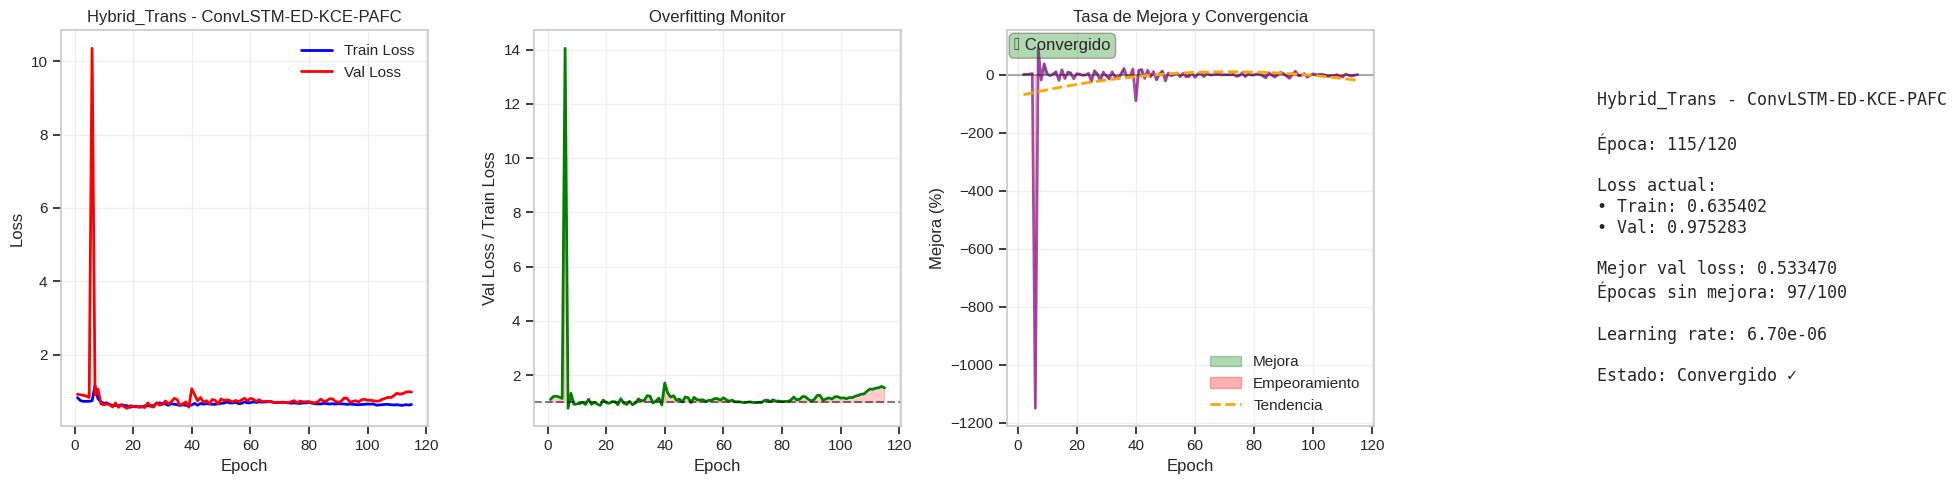


   📊 Resumen de entrenamiento Hybrid_Trans - ConvLSTM-ED-KCE-PAFC:
      • Épocas totales: 118
      • Loss final (train): 0.643277
      • Loss final (val): 0.995633
      • Mejor loss (val): 0.533470 en época 18
      • Learning rate final: No disponible


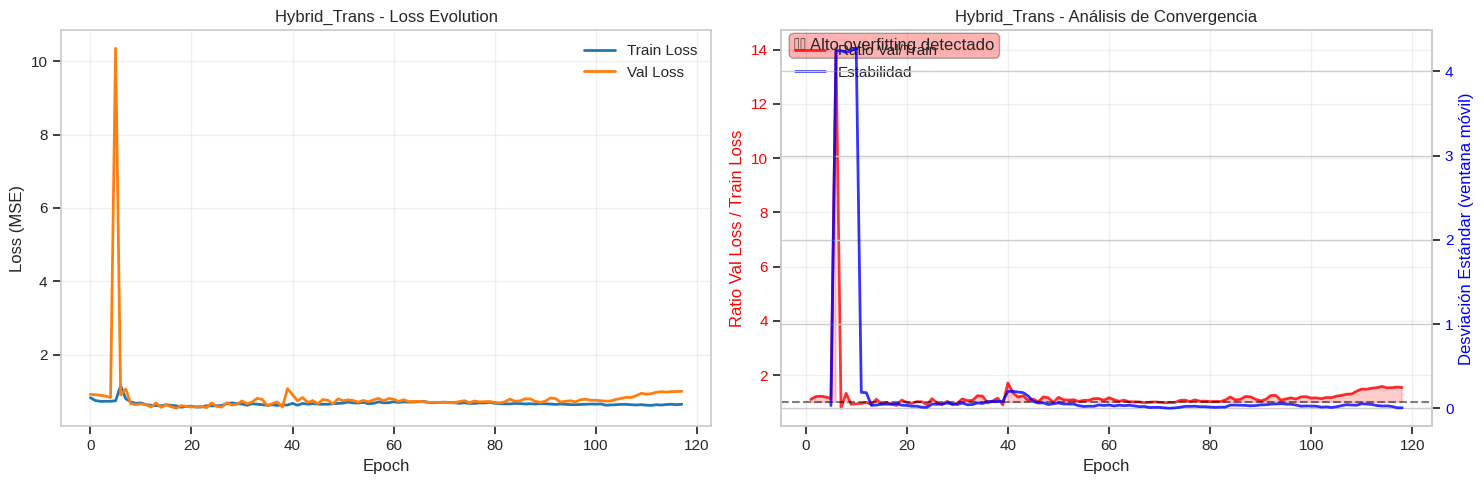


📊 Evaluando en test set...
   Test Loss: 0.613552, Test MAE: 0.593252

🎯 Generando predicciones...
   📈 H=1: RMSE=65.7441, MAE=50.6994, R²=0.4519
   📈 H=2: RMSE=62.5377, MAE=47.2545, R²=0.5103
   📈 H=3: RMSE=69.5242, MAE=51.9263, R²=0.4045

🎨 Generando visualizaciones...
   ✅ GIF guardado: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED-KCE-PAFC/Hybrid_Trans.gif

📑 Metrics saved → /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/metrics_advanced.csv


In [10]:
# ───────────────────────── TRAIN + EVAL LOOP ─────────────────────────

# Dictionary for storing training histories
all_histories = {}
results = []

for exp_name, exp_cfg in EXPERIMENTS.items():

    # Ensure the experiment is active (based on the original definition)
    if not exp_cfg.get('active', True): # Safely get 'active', default to True if missing
         print(f"\nSkipping inactive experiment: {exp_name}")
         continue

    feat_list = exp_cfg['feature_list'] # Get the list of feature names
    print(f"\n{'='*70}")
    print(f"🔬 EXPERIMENT: {exp_name} ({len(feat_list)} features)")
    print(f"{'='*70}")

    # Prepare data
    Xarr = ds[feat_list].to_array().transpose('time','latitude','longitude','variable').values.astype(np.float32)
    yarr = ds['total_precipitation'].values.astype(np.float32)[...,None]
    X, y = windowed_arrays(Xarr, yarr)
    split = int(0.8*len(X))
    val_split = int(0.9*len(X))

    # Normalization
    sx = StandardScaler().fit(X[:split].reshape(-1,len(feat_list)))
    sy = StandardScaler().fit(y[:split].reshape(-1,1))
    X_sc = sx.transform(X.reshape(-1,len(feat_list))).reshape(X.shape)
    y_sc = sy.transform(y.reshape(-1,1)).reshape(y.shape)

    # Splits
    X_tr, X_va, X_te = X_sc[:split], X_sc[split:val_split], X_sc[val_split:]
    y_tr, y_va, y_te = y_sc[:split], y_sc[split:val_split], y_sc[val_split:]

    print(f"   Datos: Train={len(X_tr)}, Val={len(X_va)}, Test={len(X_te)}")

    OUT_EXP = OUT_ROOT/exp_name
    OUT_EXP.mkdir(exist_ok=True)

    # Create subdirectory for training metrics
    METRICS_DIR = OUT_EXP / 'training_metrics'
    METRICS_DIR.mkdir(exist_ok=True)

    for mdl_name, builder in ADVANCED_MODELS.items():
        print(f"\n{'─'*50}")
        print(f"🤖 Modelo: {mdl_name}")
        print(f"{'─'*50}")

        model_path = OUT_EXP/f"{mdl_name.lower()}_best.keras"
        if model_path.exists():
            model_path.unlink()

        try:
            # Build model
            model = builder(n_feats=len(feat_list))

            # Define optimizer with explicit configuration
            optimizer = AdamW(learning_rate=LR, weight_decay=L2_REG)
            model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

            # Hyperparameters
            hyperparams = {
                'experiment': exp_name,
                'model': mdl_name,
                'features': [str(f) for f in feat_list],  # Convert to strings
                'n_features': int(len(feat_list)),
                'input_window': int(INPUT_WINDOW),
                'horizon': int(HORIZON),
                'batch_size': int(BATCH_SIZE),
                'initial_lr': float(LR),
                'epochs': int(EPOCHS),
                'patience': int(PATIENCE),
                'dropout': float(DROPOUT),
                'l2_reg': float(L2_REG),
                'train_samples': int(len(X_tr)),
                'val_samples': int(len(X_va)),
                'test_samples': int(len(X_te)),
                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'model_params': int(model.count_params())
            }

            # Save hyperparameters
            save_hyperparameters(METRICS_DIR, mdl_name, hyperparams)

            # Callbacks
            callbacks = create_callbacks(mdl_name, exp_name, model_path)

            # Train with verbose=0 to use our custom monitor
            print(f"\n🏃 Iniciando entrenamiento...")
            print(f"   📊 Visualización en tiempo real activada")
            print(f"   📈 Parámetros del modelo: {model.count_params():,}")

            history = model.fit(
                X_tr, y_tr,
                validation_data=(X_va, y_va),
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                callbacks=callbacks,
                verbose=0  # Use 0 to only show our custom monitor
            )

            # Save history
            all_histories[f"{exp_name}_{mdl_name}"] = history

            # Show training summary
            print_training_summary(history, mdl_name, exp_name)

            # Plot and save learning curves
            plot_learning_curves(history, METRICS_DIR, mdl_name, show=True)

            # Save history as JSON
            # Get learning rates from training monitor if not in history
            training_monitor = [cb for cb in callbacks if isinstance(cb, AdvancedTrainingMonitor)][0]
            lr_values = history.history.get('lr', [])
            if not lr_values and hasattr(training_monitor, 'history'):
                lr_values = training_monitor.history['lr']

            history_dict = {
                'loss': [float(x) for x in history.history['loss']],
                'val_loss': [float(x) for x in history.history['val_loss']],
                'mae': [float(x) for x in history.history.get('mae', [])],
                'val_mae': [float(x) for x in history.history.get('val_mae', [])],
                'lr': [float(x) for x in lr_values] if lr_values else []
            }

            with open(METRICS_DIR / f"{mdl_name}_history.json", 'w') as f:
                json.dump(history_dict, f, indent=4)

            # ─ Evaluation on Test Set ─
            print(f"\n📊 Evaluating on test set...")
            test_loss, test_mae = model.evaluate(X_te, y_te, verbose=0)
            print(f"   Test Loss: {test_loss:.6f}, Test MAE: {test_mae:.6f}")

            # ─ Predictions and visualization ─
            print(f"\n🎯 Generating predictions...")
            # Use the first 5 samples of the test set
            sample_indices = min(5, len(X_te))
            y_hat_sc = model.predict(X_te[:sample_indices], verbose=0)
            y_hat = sy.inverse_transform(y_hat_sc.reshape(-1,1)).reshape(-1,HORIZON,lat,lon)
            y_true = sy.inverse_transform(y_te[:sample_indices].reshape(-1,1)).reshape(-1,HORIZON,lat,lon)

            # ─ Evaluation metrics by horizon ─
            for h in range(HORIZON):
                rmse = np.sqrt(mean_squared_error(y_true[:,h].ravel(), y_hat[:,h].ravel()))
                mae = mean_absolute_error(y_true[:,h].ravel(), y_hat[:,h].ravel())
                r2 = r2_score(y_true[:,h].ravel(), y_hat[:,h].ravel())

                results.append({
                    'Experiment': exp_name,
                    'Model': mdl_name,
                    'H': h+1,
                    'RMSE': rmse,
                    'MAE': mae,
                    'R2': r2,
                    'Test_Loss': test_loss,
                    'Parameters': model.count_params()
                })

                print(f"   📈 H={h+1}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

            # ─ Maps & GIF ─
            print(f"\n🎨 Generating visualizations...")
            # Use the first sample for visualization
            sample_idx = 0
            vmin, vmax = 0, max(y_true[sample_idx].max(), y_hat[sample_idx].max())
            frames = []
            dates = pd.date_range(ds.time.values[-HORIZON], periods=HORIZON, freq='MS')

            for h in range(HORIZON):
                err = np.clip(np.abs((y_true[sample_idx,h]-y_hat[sample_idx,h])/(y_true[sample_idx,h]+1e-5))*100, 0, 100)
                try:
                    import cartopy.crs as ccrs
                    fig, axs = plt.subplots(1, 3, figsize=(16, 4.5), subplot_kw={'projection': ccrs.PlateCarree()})
                except ImportError:
                    fig, axs = plt.subplots(1, 3, figsize=(16, 4.5))

                # Real
                real_mesh = axs[0].pcolormesh(ds.longitude, ds.latitude, y_true[sample_idx,h],
                                            cmap='Blues', shading='nearest', vmin=vmin, vmax=vmax,
                                            transform=ccrs.PlateCarree())
                axs[0].coastlines()
                axs[0].add_geometries(DEPT_GDF.geometry, ccrs.PlateCarree(),
                                    edgecolor='black', facecolor='none', linewidth=1)
                axs[0].gridlines(draw_labels=False, linewidth=.5, linestyle='--', alpha=.4)
                axs[0].set_title(f"Real h={h+1}", fontsize=11)
                real_cbar = fig.colorbar(real_mesh, ax=axs[0], fraction=0.046, pad=0.04)
                real_cbar.set_label('Precipitation (mm)', rotation=270, labelpad=15)

                # Prediction
                pred_mesh = axs[1].pcolormesh(ds.longitude, ds.latitude, y_hat[sample_idx,h],
                                            cmap='Blues', shading='nearest', vmin=vmin, vmax=vmax,
                                            transform=ccrs.PlateCarree())
                axs[1].coastlines()
                axs[1].add_geometries(DEPT_GDF.geometry, ccrs.PlateCarree(),
                                     edgecolor='black', facecolor='none', linewidth=1)
                axs[1].gridlines(draw_labels=False, linewidth=.5, linestyle='--', alpha=.4)
                axs[1].set_title(f"{mdl_name} h={h+1}", fontsize=11)
                pred_cbar = fig.colorbar(pred_mesh, ax=axs[1], fraction=0.046, pad=0.04)
                pred_cbar.set_label('Precipitation (mm)', rotation=270, labelpad=15)

                # Error
                err_mesh = axs[2].pcolormesh(ds.longitude, ds.latitude, err,
                                           cmap='Reds', shading='nearest', vmin=0, vmax=100,
                                           transform=ccrs.PlateCarree())
                axs[2].coastlines()
                axs[2].add_geometries(DEPT_GDF.geometry, ccrs.PlateCarree(),
                                    edgecolor='black', facecolor='none', linewidth=1)
                axs[2].gridlines(draw_labels=False, linewidth=.5, linestyle='--', alpha=.4)
                axs[2].set_title(f"MAPE% h={h+1}", fontsize=11)
                err_cbar = fig.colorbar(err_mesh, ax=axs[2], fraction=0.046, pad=0.04)
                err_cbar.set_label('MAPE (%)', rotation=270, labelpad=15)

                fig.suptitle(f"{mdl_name} – {exp_name} – {dates[h].strftime('%Y-%m')}", fontsize=13)
                png = OUT_EXP/f"{mdl_name}_{h+1}.png"
                fig.tight_layout()
                fig.savefig(png, bbox_inches='tight')
                plt.close(fig)
                frames.append(imageio.imread(png))

            imageio.mimsave(OUT_EXP/f"{mdl_name}.gif", frames, fps=0.5)
            print(f"   ✅ GIF saved: {OUT_EXP/f'{mdl_name}.gif'}")

            tf.keras.backend.clear_session()
            gc.collect()

        except Exception as e:
            print(f"  ⚠️ Error in {mdl_name}: {str(e)}")
            print(f"  → Skipping {mdl_name} for {exp_name}")
            import traceback
            traceback.print_exc()
            continue

# ───────────────────────── CSV FINAL ─────────────────────────
res_df = pd.DataFrame(results)
res_df.to_csv(OUT_ROOT/'metrics_advanced.csv', index=False)
print("\n📑 Metrics saved →", OUT_ROOT/'metrics_advanced.csv')



📊 GENERANDO VISUALIZACIONES COMPARATIVAS


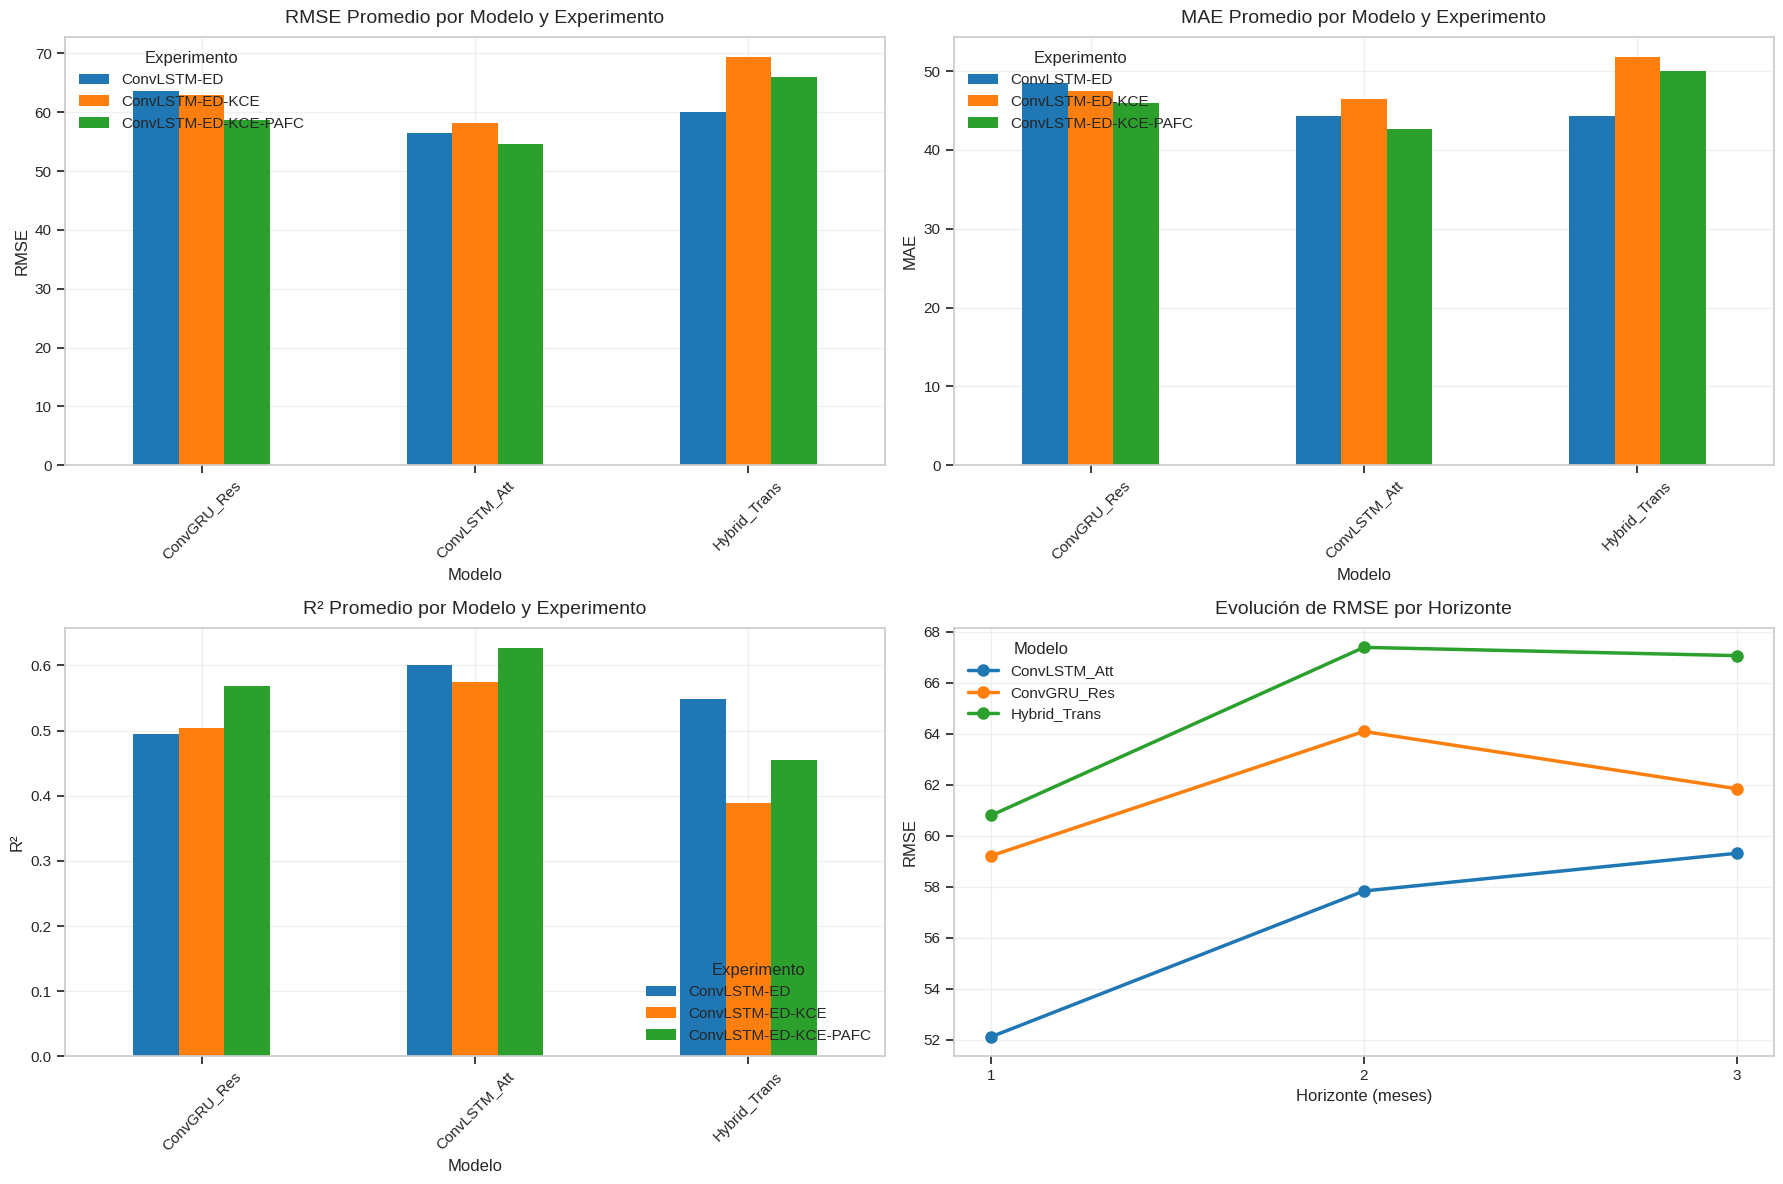


📋 TABLA RESUMEN - MEJORES MODELOS POR EXPERIMENTO:
────────────────────────────────────────────────────────────
                             Model       RMSE        MAE        R2
Experiment                                                        
ConvLSTM-ED           ConvLSTM_Att  53.888070  41.299667  0.631742
ConvLSTM-ED-KCE       ConvLSTM_Att  52.634929  41.261227  0.648670
ConvLSTM-ED-KCE-PAFC  ConvLSTM_Att  49.822110  38.525764  0.685217

📊 COMPARACIÓN CON MODELOS ORIGINALES:
────────────────────────────────────────────────────────────

ConvLSTM-ED:
  • No hay datos originales para comparar

ConvLSTM-ED-KCE:
  • No hay datos originales para comparar

ConvLSTM-ED-KCE-PAFC:
  • No hay datos originales para comparar

✅ Visualizaciones comparativas completadas!
📂 Resultados guardados en: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/comparisons


In [11]:
# ───────────────────────── COMPARATIVE VISUALIZATION ─────────────────────────
print("\n" + "="*70)
print("📊 GENERATING COMPARATIVE VISUALIZATIONS")
print("="*70)

# Create directory for comparisons
COMP_DIR = OUT_ROOT / 'comparisons'
COMP_DIR.mkdir(exist_ok=True)

# 1. Comparison of metrics between models
if 'res_df' in locals() and res_df is not None and len(res_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # RMSE by model and experiment
    pivot_rmse = res_df.pivot_table(values='RMSE', index='Model', columns='Experiment', aggfunc='mean')
    pivot_rmse.plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('RMSE Average by Model and Experiment', fontsize=14, pad=10)
    axes[0,0].set_ylabel('RMSE')
    axes[0,0].set_xlabel('Model')
    axes[0,0].legend(title='Experiment', loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)

    # MAE by model and experiment
    pivot_mae = res_df.pivot_table(values='MAE', index='Model', columns='Experiment', aggfunc='mean')
    pivot_mae.plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('MAE Average by Model and Experiment', fontsize=14, pad=10)
    axes[0,1].set_ylabel('MAE')
    axes[0,1].set_xlabel('Model')
    axes[0,1].legend(title='Experiment', loc='upper left')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].tick_params(axis='x', rotation=45)

    # R² by model and experiment
    pivot_r2 = res_df.pivot_table(values='R2', index='Model', columns='Experiment', aggfunc='mean')
    pivot_r2.plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('R² Average by Model and Experiment', fontsize=14, pad=10)
    axes[1,0].set_ylabel('R²')
    axes[1,0].set_xlabel('Model')
    axes[1,0].legend(title='Experiment', loc='lower right')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].tick_params(axis='x', rotation=45)

    # Evolution of metrics by horizon
    ax_horizon = axes[1,1]

    for model in res_df['Model'].unique():
        model_data = res_df[res_df['Model'] == model]
        horizon_means = model_data.groupby('H')['RMSE'].mean()
        ax_horizon.plot(horizon_means.index, horizon_means.values,
                       marker='o', label=model, linewidth=2.5, markersize=8)

    ax_horizon.set_xlabel('Horizon (months)')
    ax_horizon.set_ylabel('RMSE')
    ax_horizon.set_title('Evolution of RMSE by Horizon', fontsize=14, pad=10)
    ax_horizon.legend(title='Model', loc='best')
    ax_horizon.grid(True, alpha=0.3)
    ax_horizon.set_xticks([1, 2, 3])

    plt.tight_layout()
    plt.savefig(COMP_DIR / 'metrics_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# 2. Summary table of best models
if 'res_df' in locals() and res_df is not None and len(res_df) > 0:
    print("\n📋 SUMMARY TABLE - BEST MODELS BY EXPERIMENT:")
    print("─" * 60)

    best_models = res_df.groupby('Experiment').apply(
        lambda x: x.loc[x['RMSE'].idxmin()]
    )[['Model', 'RMSE', 'MAE', 'R2']]

    print(best_models.to_string())
else:
    print("\n⚠️ No results available to show the summary")

# 3. Comparison with original models if they exist
old_metrics_path = BASE_PATH / 'models' / 'output' / 'Spatial_CONVRNN' / 'metrics_spatial.csv'
if old_metrics_path.exists():
    print("\n📊 COMPARISON WITH ORIGINAL MODELS:")
    print("─" * 60)

    old_df = pd.read_csv(old_metrics_path)

    # Calculate average improvements
    if 'res_df' in locals() and res_df is not None and len(res_df) > 0:
        for exp in EXPERIMENTS.keys():
            print(f"\n{exp}:")

            # Best new models
            exp_data = res_df[res_df['Experiment'] == exp]
            if len(exp_data) > 0:
                new_best = exp_data.groupby('Model')['RMSE'].mean().idxmin()
                new_rmse = exp_data[exp_data['Model'] == new_best]['RMSE'].mean()

                # Best original model
                old_exp_data = old_df[old_df['Experiment'] == exp]
                if len(old_exp_data) > 0:
                    old_best_rmse = old_exp_data['RMSE'].min()

                    improvement = (old_best_rmse - new_rmse) / old_best_rmse * 100

                    print(f"  • Best new model: {new_best} (RMSE: {new_rmse:.4f})")
                    print(f"  • Best original RMSE: {old_best_rmse:.4f}")
                    print(f"  • Improvement: {improvement:.2f}%")
                else:
                    print(f"  • No original data to compare")

print("\n✅ Comparative visualizations completed!")
print(f"📂 Results saved in: {COMP_DIR}")



📊 ANÁLISIS DETALLADO DE RESULTADOS


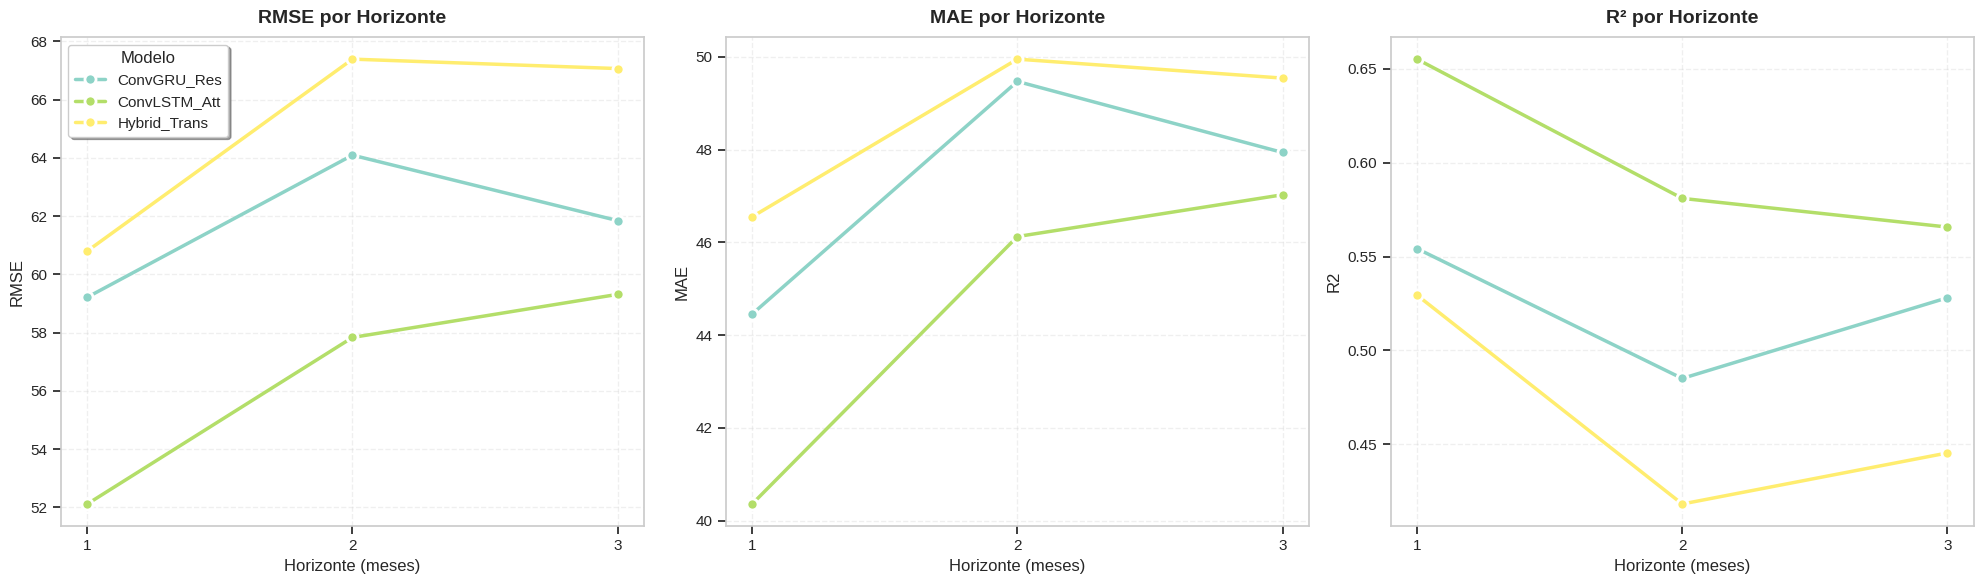

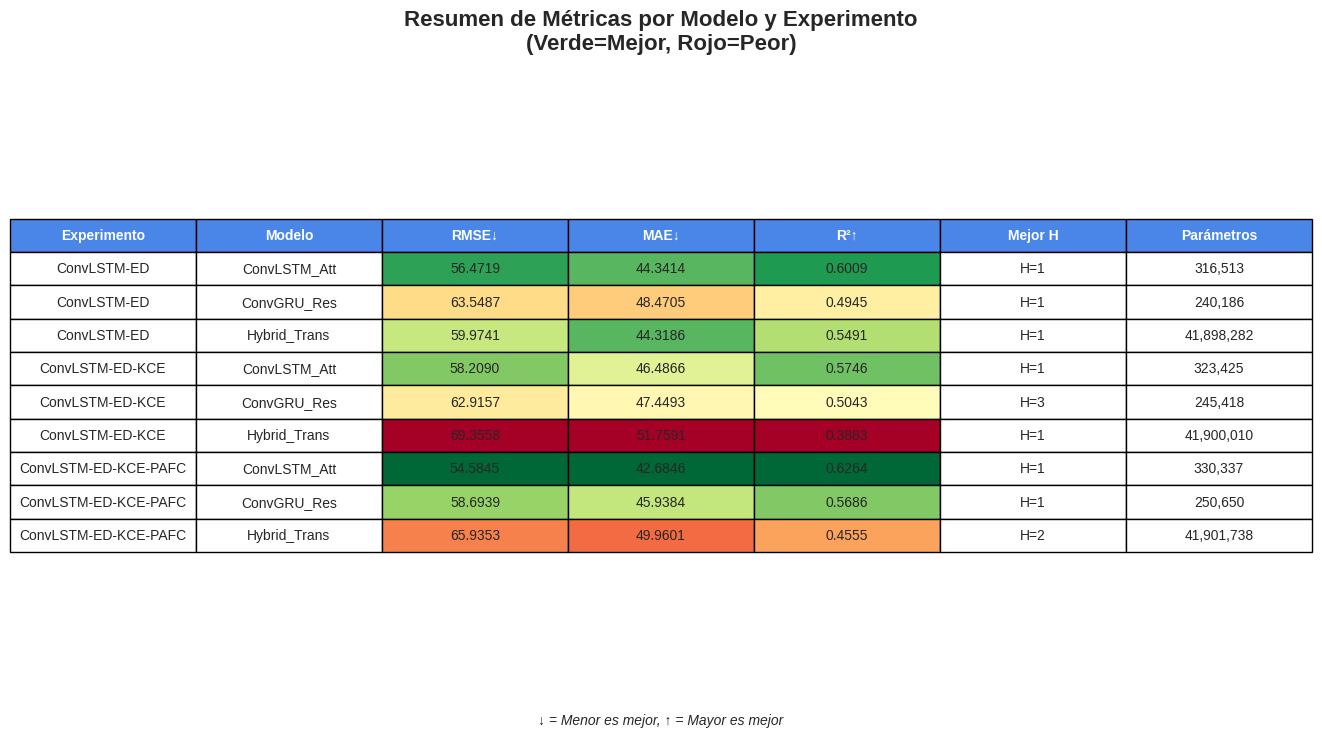


🏆 MEJOR MODELO GLOBAL:
──────────────────────────────────────────────────
Modelo: ConvLSTM_Att
Experimento: ConvLSTM-ED-KCE-PAFC
Horizonte: 1
RMSE: 49.8221
MAE: 38.5258
R²: 0.6852
Score compuesto: 1.0000

📈 ANÁLISIS DE MEJORA POR HORIZONTE:
──────────────────────────────────────────────────

Horizonte 1:
  • Mejor modelo: ConvLSTM_Att - ConvLSTM-ED-KCE-PAFC
  • RMSE: 49.8221
  • R²: 0.6852

Horizonte 2:
  • Mejor modelo: ConvLSTM_Att - ConvLSTM-ED-KCE-PAFC
  • RMSE: 56.6616
  • R²: 0.5980

Horizonte 3:
  • Mejor modelo: ConvLSTM_Att - ConvLSTM-ED-KCE-PAFC
  • RMSE: 57.2698
  • R²: 0.5959

✅ Análisis detallado completado!


In [12]:
# ───────────────────────── DETAILED ANALYSIS OF RESULTS ─────────────────────────

if 'res_df' in locals() and res_df is not None and len(res_df) > 0:
    print("\n" + "="*70)
    print("📊 DETAILED ANALYSIS OF RESULTS")
    print("="*70)

    # 1. Metrics by prediction horizon
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    metrics = ['RMSE', 'MAE', 'R2']
    titles = ['RMSE by Horizon', 'MAE by Horizon', 'R² by Horizon']
    colors = plt.cm.Set3(np.linspace(0, 1, len(res_df['Model'].unique())))

    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx]

        # Get pivoted data
        data = res_df.groupby(['H', 'Model'])[metric].mean().unstack()

        # Plot each model
        for i, model in enumerate(data.columns):
            ax.plot(data.index, data[model],
                   marker='o',
                   label=model,
                   color=colors[i],
                   linewidth=2.5,
                   markersize=8,
                   markeredgewidth=2,
                   markeredgecolor='white')

        ax.set_xlabel('Horizon (months)', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_xticks(data.index)

        # Legend only in the first graph
        if idx == 0:
            ax.legend(title='Model', loc='best', frameon=True, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.savefig(COMP_DIR / 'metrics_evolution_by_horizon.png', dpi=150, bbox_inches='tight')
    plt.show()

    # 2. Visual table of metrics
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.axis('tight')
    ax.axis('off')

    # Prepare data for the table
    summary_data = []
    experiments = res_df['Experiment'].unique()
    models = res_df['Model'].unique()

    # Headers
    headers = ['Experimento', 'Modelo', 'RMSE↓', 'MAE↓', 'R²↑', 'Mejor H', 'Parámetros']

    for exp in experiments:
        for model in models:
            exp_model_data = res_df[(res_df['Experiment'] == exp) & (res_df['Model'] == model)]
            if not exp_model_data.empty:
                avg_rmse = exp_model_data['RMSE'].mean()
                avg_mae = exp_model_data['MAE'].mean()
                avg_r2 = exp_model_data['R2'].mean()
                best_h = exp_model_data.loc[exp_model_data['RMSE'].idxmin(), 'H']
                params = exp_model_data['Parameters'].iloc[0]

                summary_data.append([
                    exp, model,
                    f'{avg_rmse:.4f}',
                    f'{avg_mae:.4f}',
                    f'{avg_r2:.4f}',
                    f'H={best_h}',
                    f'{params:,}'
                ])

    # Create table
    table = ax.table(cellText=summary_data, colLabels=headers,
                    cellLoc='center', loc='center')

    # Style table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)

    # Color cells according to performance
    for i in range(len(summary_data)):
        # Get values for comparison
        rmse_val = float(summary_data[i][2])
        mae_val = float(summary_data[i][3])
        r2_val = float(summary_data[i][4])

        # Find min/max for normalization
        all_rmse = [float(row[2]) for row in summary_data]
        all_mae = [float(row[3]) for row in summary_data]
        all_r2 = [float(row[4]) for row in summary_data]

        # Normalize and color RMSE (lower is better)
        rmse_norm = (rmse_val - min(all_rmse)) / (max(all_rmse) - min(all_rmse))
        rmse_color = plt.cm.RdYlGn(1 - rmse_norm)
        table[(i+1, 2)].set_facecolor(rmse_color)

        # Normalize and color MAE (lower is better)
        mae_norm = (mae_val - min(all_mae)) / (max(all_mae) - min(all_mae))
        mae_color = plt.cm.RdYlGn(1 - mae_norm)
        table[(i+1, 3)].set_facecolor(mae_color)

        # Normalize and color R² (higher is better)
        r2_norm = (r2_val - min(all_r2)) / (max(all_r2) - min(all_r2))
        r2_color = plt.cm.RdYlGn(r2_norm)
        table[(i+1, 4)].set_facecolor(r2_color)

        # Color experiment
        exp_colors = {'BASIC': '#e8f4f8', 'KCE': '#f0e8f8', 'PAFC': '#f8e8f0'}
        table[(i+1, 0)].set_facecolor(exp_colors.get(summary_data[i][0], 'white'))

    # Color headers
    for j in range(len(headers)):
        table[(0, j)].set_facecolor('#4a86e8')
        table[(0, j)].set_text_props(weight='bold', color='white')

    plt.title('Summary of Metrics by Model and Experiment\n(Green=Best, Red=Worst)',
             fontsize=16, fontweight='bold', pad=20)

    # Add legend
    plt.text(0.5, -0.05, '↓ = Lower is better, ↑ = Higher is better',
            transform=ax.transAxes, ha='center', fontsize=10, style='italic')

    plt.savefig(COMP_DIR / 'metrics_summary_table.png', dpi=150, bbox_inches='tight')
    plt.show()

    # 3. Identify the best global model
    print("\n🏆 BEST GLOBAL MODEL:")
    print("─" * 50)

    # Calculate composite score (normalized)
    res_df['score'] = (
        (1 - (res_df['RMSE'] - res_df['RMSE'].min()) / (res_df['RMSE'].max() - res_df['RMSE'].min())) +
        (1 - (res_df['MAE'] - res_df['MAE'].min()) / (res_df['MAE'].max() - res_df['MAE'].min())) +
        ((res_df['R2'] - res_df['R2'].min()) / (res_df['R2'].max() - res_df['R2'].min()))
    ) / 3

    best_overall = res_df.loc[res_df['score'].idxmax()]
    print(f"Model: {best_overall['Model']}")
    print(f"Experiment: {best_overall['Experiment']}")
    print(f"Horizon: {best_overall['H']}")
    print(f"RMSE: {best_overall['RMSE']:.4f}")
    print(f"MAE: {best_overall['MAE']:.4f}")
    print(f"R²: {best_overall['R2']:.4f}")
    print(f"Composite score: {best_overall['score']:.4f}")

    # 4. Analysis of improvement by horizon
    print("\n📈 ANALYSIS OF IMPROVEMENT BY HORIZON:")
    print("─" * 50)

    for h in [1, 2, 3]:
        h_data = res_df[res_df['H'] == h]
        best_h = h_data.loc[h_data['RMSE'].idxmin()]

        print(f"\nHorizon {h}:")
        print(f"  • Best model: {best_h['Model']} - {best_h['Experiment']}")
        print(f"  • RMSE: {best_h['RMSE']:.4f}")
        print(f"  • R²: {best_h['R2']:.4f}")

print("\n✅ Detailed analysis completed!")



🖼️ PREDICCIONES MÁS RECIENTES:

ConvLSTM-ED:
  ConvLSTM_Att - Primera predicción (H=1):


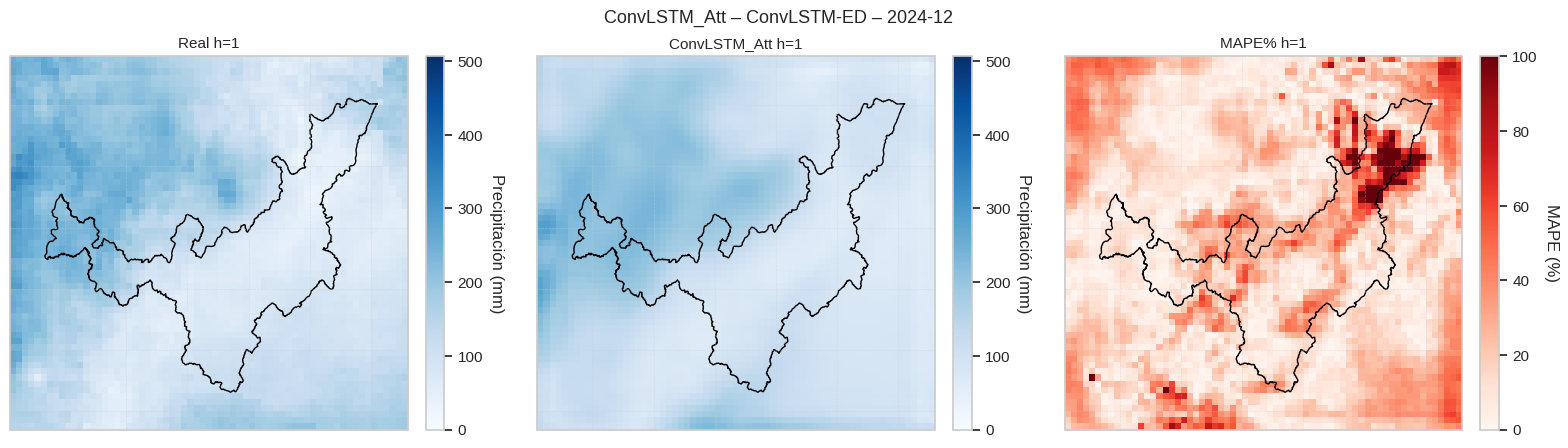

  📹 GIF animado disponible: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED/ConvLSTM_Att.gif
  ConvGRU_Res - Primera predicción (H=1):


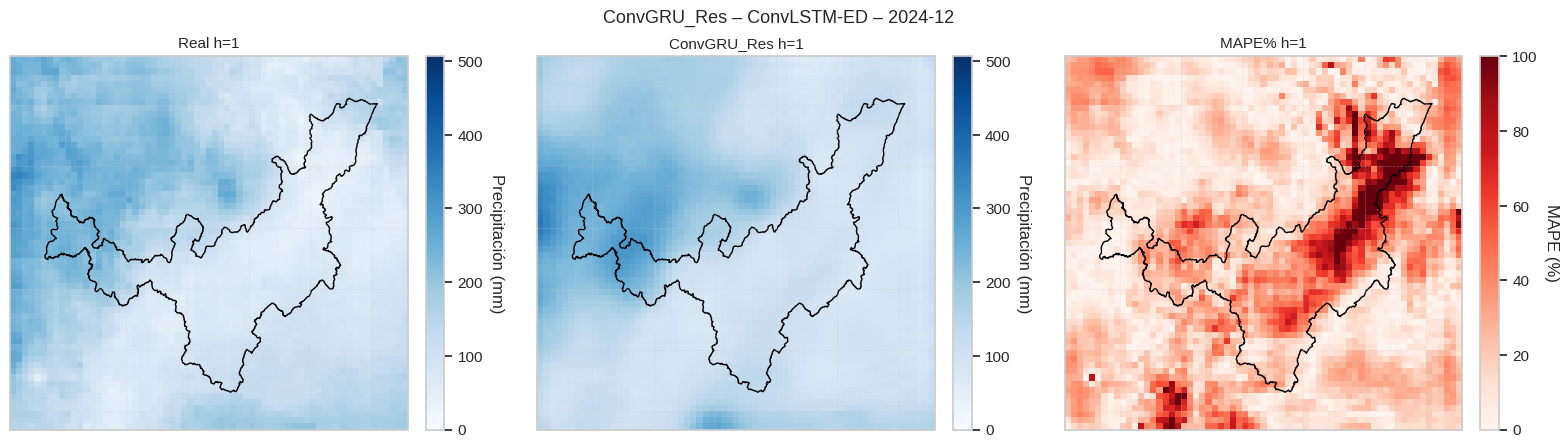

  📹 GIF animado disponible: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED/ConvGRU_Res.gif
  Hybrid_Trans - Primera predicción (H=1):


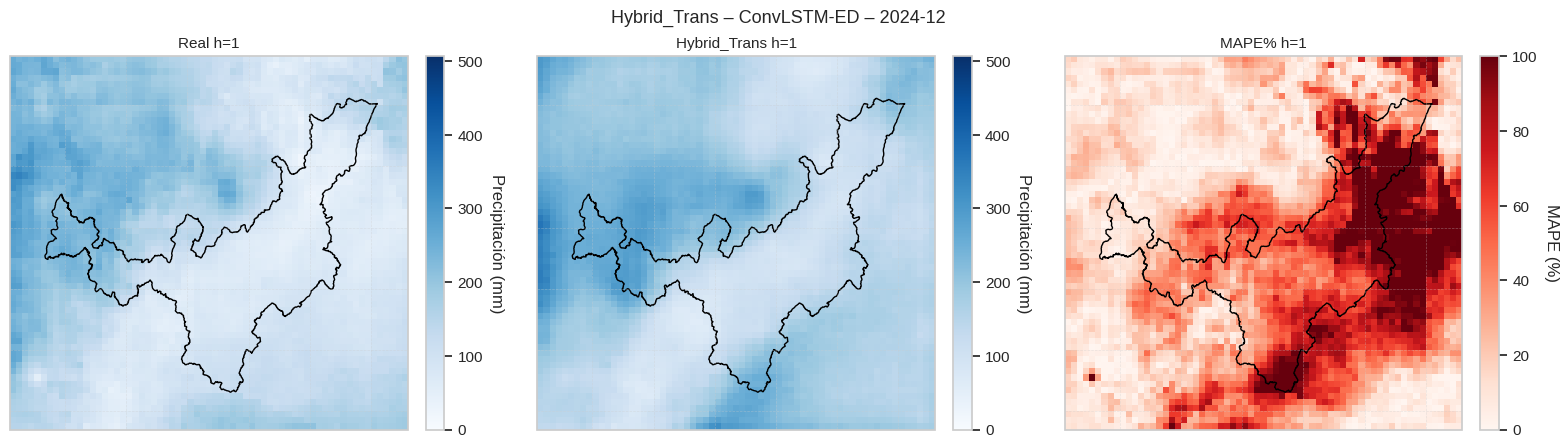

  📹 GIF animado disponible: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED/Hybrid_Trans.gif

ConvLSTM-ED-KCE:
  ConvLSTM_Att - Primera predicción (H=1):


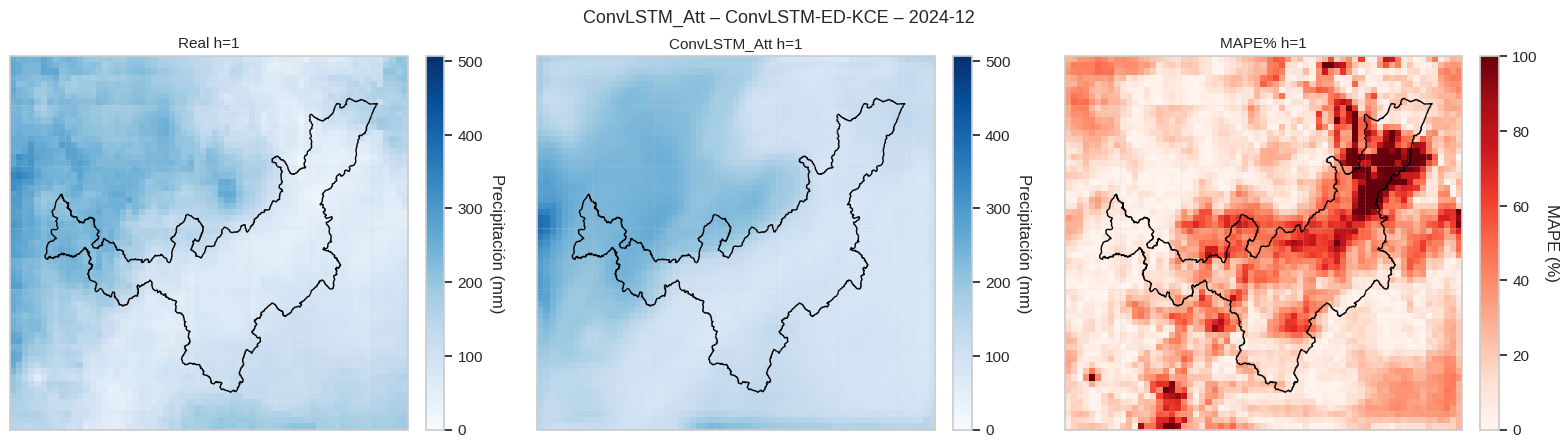

  📹 GIF animado disponible: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED-KCE/ConvLSTM_Att.gif
  ConvGRU_Res - Primera predicción (H=1):


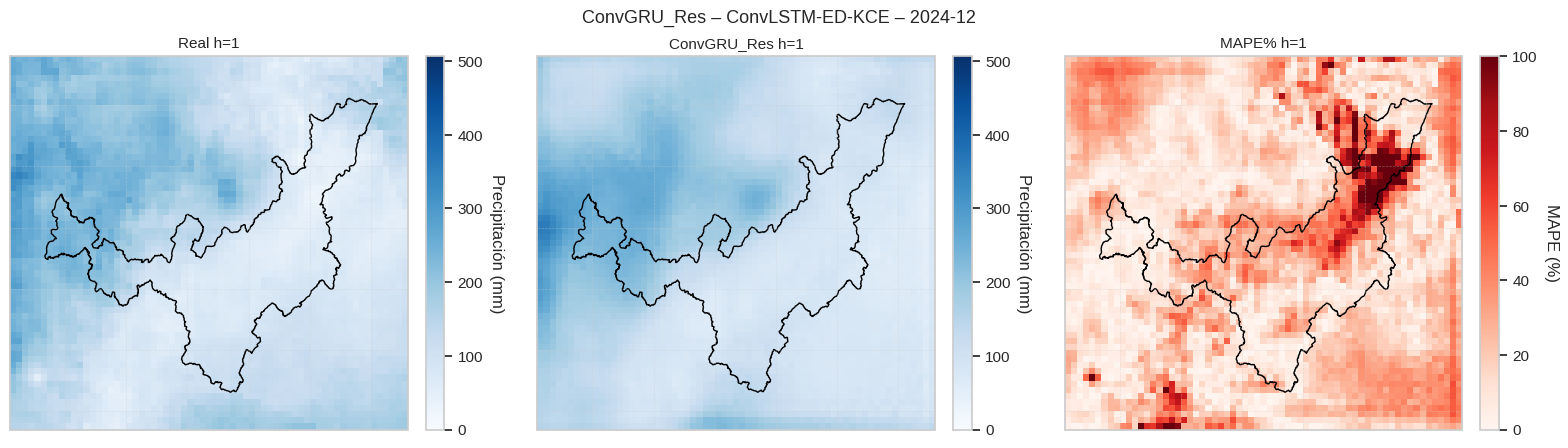

  📹 GIF animado disponible: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED-KCE/ConvGRU_Res.gif
  Hybrid_Trans - Primera predicción (H=1):


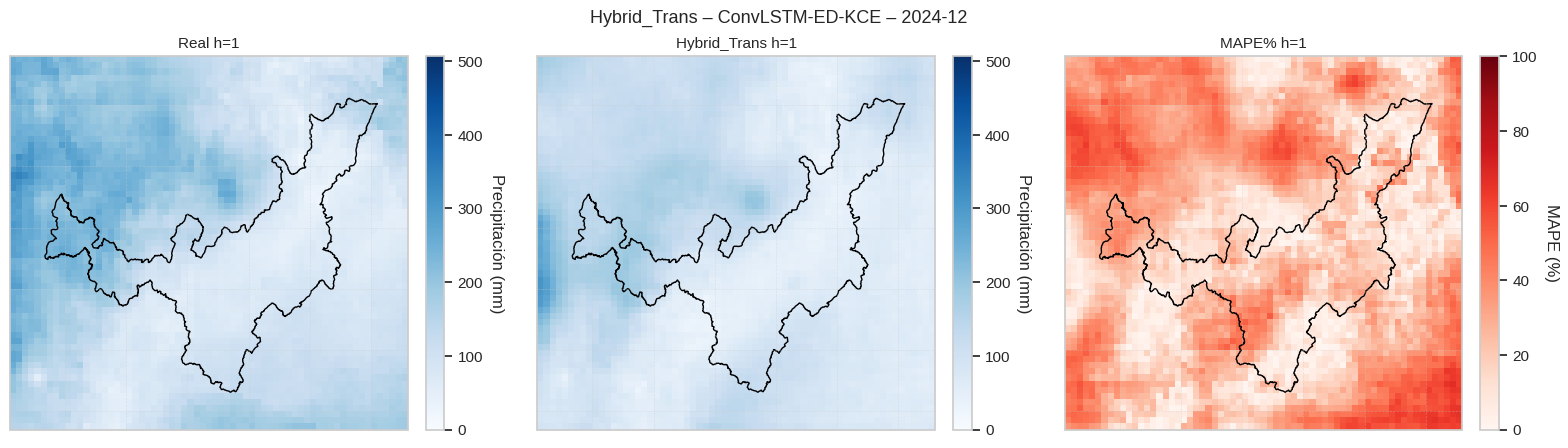

  📹 GIF animado disponible: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED-KCE/Hybrid_Trans.gif

ConvLSTM-ED-KCE-PAFC:
  ConvLSTM_Att - Primera predicción (H=1):


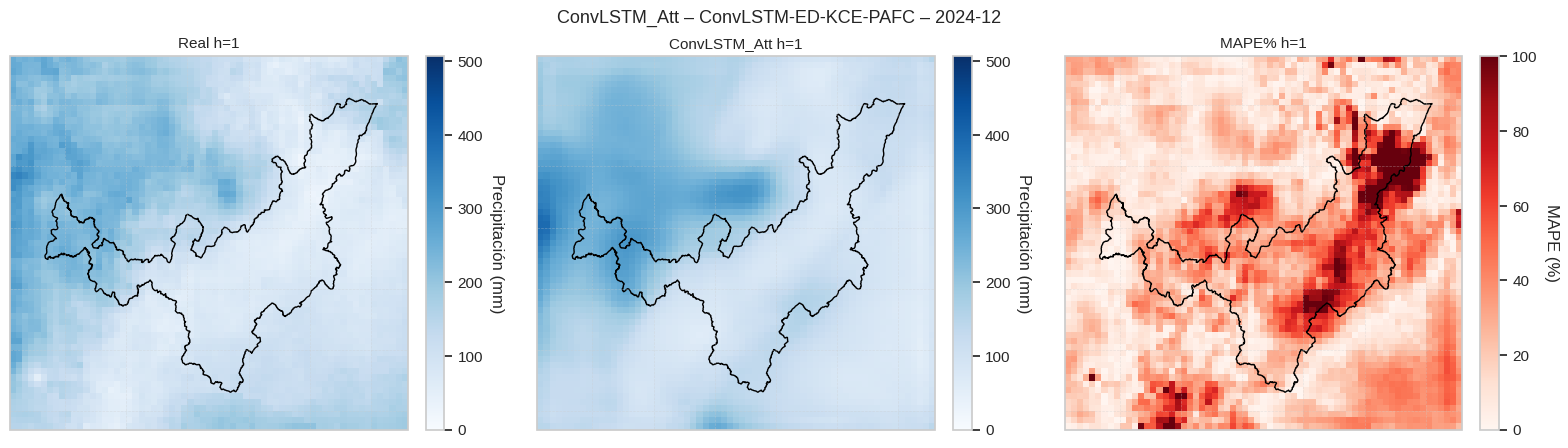

  📹 GIF animado disponible: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED-KCE-PAFC/ConvLSTM_Att.gif
  ConvGRU_Res - Primera predicción (H=1):


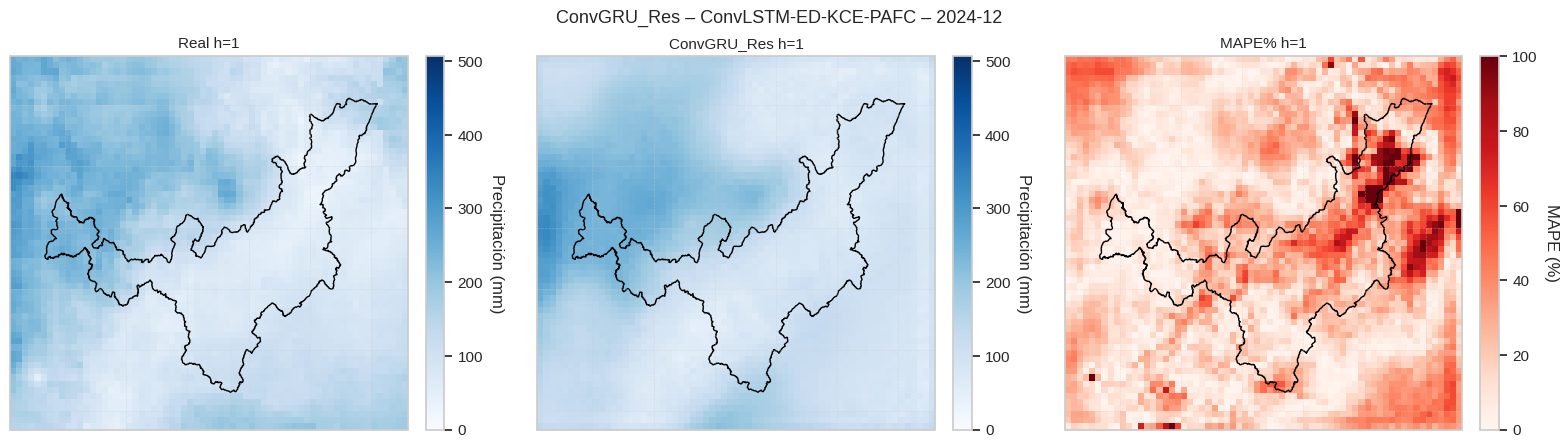

  📹 GIF animado disponible: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED-KCE-PAFC/ConvGRU_Res.gif
  Hybrid_Trans - Primera predicción (H=1):


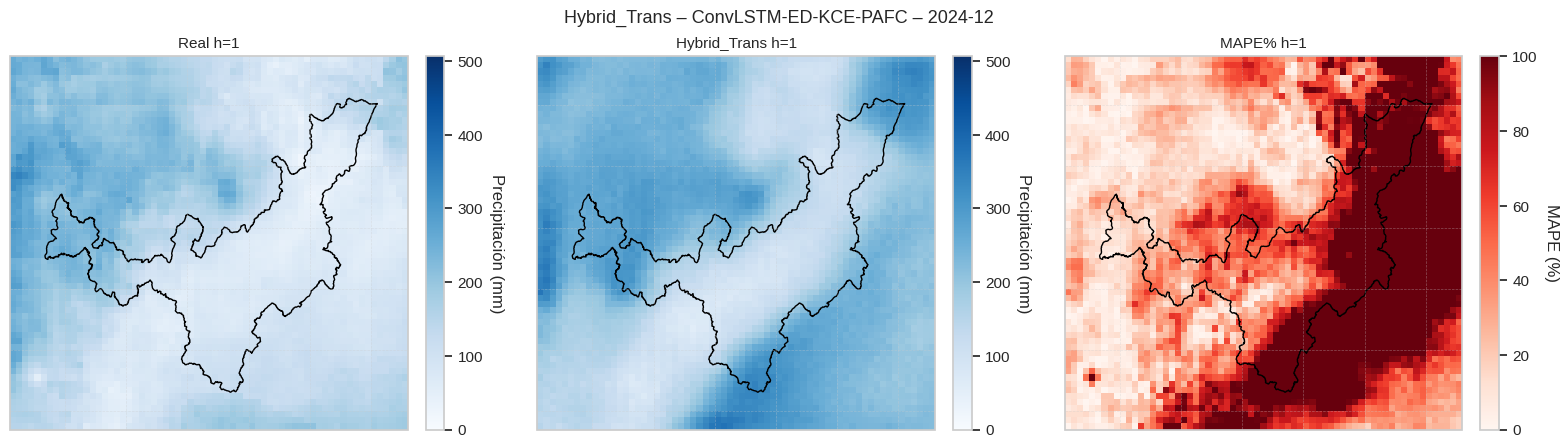

  📹 GIF animado disponible: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/ConvLSTM-ED-KCE-PAFC/Hybrid_Trans.gif

🎉 NOTEBOOK COMPLETADO!

📊 Resultados guardados en: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial
📈 Métricas en: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/metrics_advanced.csv
🖼️ Visualizaciones en: /content/drive/MyDrive/ml_precipitation_prediction/models/output/advanced_spatial/comparisons

💡 Próximos pasos:
   1. Revisar las métricas y seleccionar el mejor modelo
   2. Hacer fine-tuning de hiperparámetros si es necesario
   3. Entrenar un ensemble con los mejores modelos
   4. Evaluar en datos más recientes o diferentes regiones


In [13]:
# ───────────────────────── SHOW RECENT PREDICTIONS ─────────────────────────
print("\n🖼️ RECENT PREDICTIONS:")
for exp in EXPERIMENTS.keys():
    exp_dir = OUT_ROOT / exp
    if exp_dir.exists():
        print(f"\n{exp}:")
        # Show first image of each model
        for model in ADVANCED_MODELS.keys():
            img_path = exp_dir / f"{model}_1.png"
            gif_path = exp_dir / f"{model}.gif"

            if img_path.exists():
                from IPython.display import Image, display
                print(f"  {model} - First prediction (H=1):")
                display(Image(str(img_path), width=800))

            if gif_path.exists():
                print(f"  📹 GIF available: {gif_path}")

print("\n" + "="*70)
print("🎉 NOTEBOOK COMPLETED!")
print("="*70)
print(f"\n📊 Resultados guardados en: {OUT_ROOT}")
if 'res_df' in locals() and res_df is not None and len(res_df) > 0:
    print(f"📈 Metrics in: {OUT_ROOT/'metrics_advanced.csv'}")
    print(f"🖼️ Visualizations in: {COMP_DIR if 'COMP_DIR' in locals() else 'N/A'}")
else:
    print("⚠️ No metrics generated in this execution")
print("\n💡 Next steps:")
print("   1. Review the metrics and select the best model")
print("   2. Fine-tune hyperparameters if necessary")
print("   3. Train an ensemble with the best models")
print("   4. Evaluate on more recent or different regions")
